# Candidate Analysis on Twitter

In [378]:
import os
import sys
shared_path = '/Users/sarah/Downloads/TwitterResearch2020'
sys.path.append(shared_path)
import thinned_tweet_obj
import general_utilities
import gdrive_quickstart, io
from googleapiclient.http import MediaIoBaseDownload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [379]:
DRIVE = gdrive_quickstart.authenticate_drive_api()
file_objs_lst = gdrive_quickstart.get_file_objs_list(DRIVE, 'name contains "combined_tweets-2020"')

In [5]:
tweets_1101 = gdrive_quickstart.download_pkl_file(DRIVE, file_objs_lst[7], print_status=True)

Download 37%.
Download 74%.
Download 100%.


- Donald Trump: 
    - `user_id = 25073877`
    - `screen_name = realDonaldTrump`
    
- Joe Biden:
    - `user_id = 939091`
    - `screen_name = JoeBiden`

In [37]:
tweets_1101[1].retweet.__dict__

{'favorite_count': 132383,
 'favorited': False,
 'hashtags': [],
 'in_reply': '',
 'mentions': [],
 'quote': None,
 'quote_status': True,
 'retweet': '',
 'text': 'You heard the woman! Get in the Sienna and bring snacks!',
 'tweet_id': '1322565784778977280',
 'user': <thinned_tweet_obj.tweet_user at 0x7fa130b31190>}

Want to track:
- Tweets from candidates
- number of retweets within sample
- number of favorites
- number of replies within sample
- number of mentions

Trump / Biden dataframe:
- From a retweet or reply of a Trump / Biden tweet:
    - Check if original tweet is by Trump / Biden (`.retweet.user.user_id` or `.in_reply.author_id` match)
    - Check if the original tweet is already tracked (`.retweet.tweet_id` or `.in_reply.original_id`)
        - If it is -> increment the count, update the number of favorites (retweet)
        - If it is not -> add it (text of original tweet, Trump or Biden, number of favorites, retweet or reply)
        
| Index  | Obj_id | Tweet_id | Candidate | Text | Retweet_count | Reply_count | Favorite_count |
|--------|--------|----------|-----------|------|---------------|-------------|----------------|
| num    | thin_obj id | tweet id | Trump / Biden  | Tweet text  | num updated if retweet | num updated if reply| num updated if favorite|
        
- mentions:
    - number of Trump mentions
    - number of Biden mentions
    - status (retweet, reply, normal tweet)

In [104]:
def update_mention_dict(mention_dict, obj):
    mention_dict['mention_count'] += 1
    if obj.retweet:
        mention_dict['retweet_count'] += 1
    if obj.in_reply:
        mention_dict['reply_count'] += 1
    return mention_dict


def extract_mention_data(obj, mentions_lst):
    try:
        for mention in obj.mentions:
            if mention['screen_name'] == 'JoeBiden':
                mentions_lst[0] = update_mention_dict(mentions_lst[0], obj)
            elif mention['screen_name'] == 'realDonaldTrump':
                mentions_lst[1] = update_mention_dict(mentions_lst[1], obj)
    except:
        pass
    return mentions_lst


def add_row(tweet_id_to_row_id, rows, obj, name, retweet, reply):
    tweet_id = obj.tweet_id
    if retweet:
        tweet_id = obj.retweet.tweet_id
    elif reply:
        tweet_id = obj.in_reply.original_id
    
    update_id = -1   # This will be the row index if a row needs to be updated instead of appended
    if tweet_id in tweet_id_to_row_id:
        update_id = tweet_id_to_row_id[tweet_id]
        row_dict = rows[update_id]
    else:
        row_dict = {'tweet_id' : tweet_id, 'candidate' : name, 'text' : '', 
                    'retweet_count' : 0, 'reply_count' : 0, 'favorite_count' : 0}
        
    if retweet:
        obj = obj.retweet
        row_dict['retweet_count'] += 1
        if not row_dict['text']:
            row_dict['text'] = obj.text
        if obj.favorite_count > row_dict['favorite_count']:
            row_dict['favorite_count'] = obj.favorite_count
    elif reply:
        obj = obj.in_reply
        row_dict['reply_count'] += 1
    else:
        row_dict['text'] = obj.text
    
    return update_id, row_dict


def build_tb_tweets(obj_lst):
    '''
    Build dataframes of Trump / Biden tweets and relevant stats
    '''
    trump_user_id = '25073877'
    biden_user_id = '939091'
    
    rows_list = []  # list of dictionaries to turn into pandas dataframe
    tweet_id_to_row_id = {}  # Tweet_id -> row index
    mentions_lst = [{'candidate' : 'Biden', 'mention_count' : 0, 'retweet_count' : 0, 'reply_count' : 0},
                    {'candidate' : 'Trump', 'mention_count' : 0, 'retweet_count' : 0, 'reply_count' : 0}]
    for obj in obj_lst:
        # Update mentions if there's a mention
        mentions_lst = extract_mention_data(obj, mentions_lst)
        
        # Add or update a row to the row list
        update_id = -2
        try:
            if obj.user.user_id == trump_user_id:
                update_id, row_dict = add_row(tweet_id_to_row_id, rows_list, obj, "Trump", False, False)
            elif obj.user.user_id == biden_user_id:
                update_id, row_dict = add_row(tweet_id_to_row_id, rows_list, obj, "Biden", False, False)
            elif obj.retweet:
                if obj.retweet.user.user_id == trump_user_id:
                    update_id, row_dict = add_row(tweet_id_to_row_id, rows_list, obj, "Trump", True, False)
                elif obj.retweet.user.user_id == biden_user_id:
                    update_id, row_dict = add_row(tweet_id_to_row_id, rows_list, obj, "Biden", True, False)
            elif obj.in_reply:
                if obj.in_reply.author_id == trump_user_id:
                    update_id, row_dict = add_row(tweet_id_to_row_id, rows_list, obj, "Trump", False, True)
                elif obj.in_reply.author_id == biden_user_id:
                    update_id, row_dict = add_row(tweet_id_to_row_id, rows_list, obj, "Biden", False, True)

            if update_id == -1:
                rows_list.append(row_dict)
                tweet_id_to_row_id[row_dict['tweet_id']] = len(rows_list) - 1
            elif update_id > -1:
                rows_list[update_id] = row_dict
        except:
            pass
            
    return pd.DataFrame(rows_list), mentions_lst

In [58]:
pd.set_option('max_colwidth', 400)
# tbdf = Trump / Biden dataframe
tbdf_tweets_1101, mentions_lst_1101 = build_tb_tweets(tweets_1101)

no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute


object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions


no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute


no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute


no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute


object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions
object missing an attribute
no mentions


In [59]:
tbdf_tweets_1101

candidate  favorite_count  reply_count  retweet_count  \
0       Trump           20987           17            128   
1       Trump          328916          180            105   
2       Trump               0           50              0   
3       Trump           70900            1              5   
4       Trump               0           24              0   
5       Trump           40070            0              1   
6       Trump               0            5              0   
7       Trump           58475            6              7   
8       Trump           79973          144            287   
9       Trump               0           82              0   
10      Trump               0            5              0   
11      Biden               0            8              0   
12      Biden          125456           27             39   
13      Biden               0           12              0   
14      Biden               0           31              0   
15      Trump               0           66              0   
16      Trump               0          103              0   
17      Trump               0           94              0   
18      Biden           30725           18              8   
19      Biden           98414           15             69   
20      Biden               0           12              0   
21      Trump           42468            6             95   
22      Trump               0           31              0   
23      Trump               0           85              0   
24      Trump           64966          134            196   
25      Biden               0           64              0   
26      Trump           46563           42             17   
27      Trump          152264           61           1301   
28      Biden            9804            9              6   
29      Trump          345641            2              2   
..        ...             ...          ...            ...   
308     Biden               0            1              0   
309     Trump             419            0              1   
310     Trump               0            1              0   
311     Biden               0            1              0   
312     Biden           20780            7              7   
313     Trump               0            1              0   
314     Trump               0            1              0   
315     Biden               0            1              0   
316     Biden               0            1              0   
317     Biden          128722            0              1   
318     Trump               0            1              0   
319     Trump               0            1              0   
320     Trump               0            1              0   
321     Trump          217310            1              1   
322     Trump            1324            0              1   
323     Trump            1516            0              1   
324     Trump               0            1              0   
325     Trump           17944            0              2   
326     Trump               0            1              0   
327     Trump          178664            0              1   
328     Biden          154339            0              1   
329     Trump               0            1              0   
330     Trump          114058            0              3   
331     Trump               0            1              0   
332     Biden          138841            0              2   
333     Trump           69843            0              1   
334     Biden           72155            0              1   
335     Trump          111073            0              1   
336     Trump               0            1              0   
337     Trump               0            1              0   

                                                                                                                                                                                                                             

In [60]:
mentions_lst_1101

[{'candidate': 'Biden',
  'mention_count': 9197,
  'reply_count': 3652,
  'retweet_count': 4523},
 {'candidate': 'Trump',
  'mention_count': 33198,
  'reply_count': 10927,
  'retweet_count': 20212}]

# Sentiment of candidate tweets

In [61]:
# Using Vader for sentiment analysis (looks at words in context)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
from afinn import Afinn
af = Afinn(language="en")

In [62]:
tbdf_tweets_1101['afinn_score'] = tbdf_tweets_1101['text'].apply(af.score)

sentiment_vader = tbdf_tweets_1101['text'].apply(vader.polarity_scores)
sentiment_v_df = pd.DataFrame(sentiment_vader.tolist())
tbdf_tweets_1101['vader_compound'] = sentiment_v_df['compound']

tbdf_tweets_1101

candidate  favorite_count  reply_count  retweet_count  \
0       Trump           20987           17            128   
1       Trump          328916          180            105   
2       Trump               0           50              0   
3       Trump           70900            1              5   
4       Trump               0           24              0   
5       Trump           40070            0              1   
6       Trump               0            5              0   
7       Trump           58475            6              7   
8       Trump           79973          144            287   
9       Trump               0           82              0   
10      Trump               0            5              0   
11      Biden               0            8              0   
12      Biden          125456           27             39   
13      Biden               0           12              0   
14      Biden               0           31              0   
15      Trump               0           66              0   
16      Trump               0          103              0   
17      Trump               0           94              0   
18      Biden           30725           18              8   
19      Biden           98414           15             69   
20      Biden               0           12              0   
21      Trump           42468            6             95   
22      Trump               0           31              0   
23      Trump               0           85              0   
24      Trump           64966          134            196   
25      Biden               0           64              0   
26      Trump           46563           42             17   
27      Trump          152264           61           1301   
28      Biden            9804            9              6   
29      Trump          345641            2              2   
..        ...             ...          ...            ...   
308     Biden               0            1              0   
309     Trump             419            0              1   
310     Trump               0            1              0   
311     Biden               0            1              0   
312     Biden           20780            7              7   
313     Trump               0            1              0   
314     Trump               0            1              0   
315     Biden               0            1              0   
316     Biden               0            1              0   
317     Biden          128722            0              1   
318     Trump               0            1              0   
319     Trump               0            1              0   
320     Trump               0            1              0   
321     Trump          217310            1              1   
322     Trump            1324            0              1   
323     Trump            1516            0              1   
324     Trump               0            1              0   
325     Trump           17944            0              2   
326     Trump               0            1              0   
327     Trump          178664            0              1   
328     Biden          154339            0              1   
329     Trump               0            1              0   
330     Trump          114058            0              3   
331     Trump               0            1              0   
332     Biden          138841            0              2   
333     Trump           69843            0              1   
334     Biden           72155            0              1   
335     Trump          111073            0              1   
336     Trump               0            1              0   
337     Trump               0            1              0   

                                                                                                                                                                                                                             

In [68]:
biden_1101 = tbdf_tweets_1101.loc[tbdf_tweets_1101.candidate == 'Biden']
biden_1101.head()

candidate  favorite_count  reply_count  retweet_count  \
11     Biden               0            8              0   
12     Biden          125456           27             39   
13     Biden               0           12              0   
14     Biden               0           31              0   
18     Biden           30725           18              8   

                                                                                                                                                                                                                                                         text  \
11                                                                                                                                                                                                                                                              
12                                                                                                                                                                                            Let’s put dogs back in the White House. https://t.co/7pBihksfXT   
13                                                                                                                                                                                                                                                              
14                                                                                                                                                                                                                                                              
18  My faith has been a source of immeasurable solace in times of grief and a daily inspiration to fight against the abuse of power in all its forms. As president, it will continue to serve as my anchor, as it has my entire life. https://t.co/C5OqUaJKWd   

               tweet_id  afinn_score  vader_compound  
11  1322876039144636417          0.0          0.0000  
12  1322871257902145536          0.0          0.0000  
13  1322892363350577154          0.0          0.0000  
14  1322881072363917312          0.0          0.0000  
18  1322901204943491073         -3.0         -0.5859

In [69]:
trump_1101 = tbdf_tweets_1101.loc[tbdf_tweets_1101.candidate == 'Trump']
trump_1101.head()

candidate  favorite_count  reply_count  retweet_count  \
0     Trump           20987           17            128   
1     Trump          328916          180            105   
2     Trump               0           50              0   
3     Trump           70900            1              5   
4     Trump               0           24              0   

                                                                                                                                                                                                                                                                          text  \
0                            Congressman (@JDanBishop) is doing a terrific job for North Carolina! In Congress, Dan fights to Create Jobs, Strengthen our Military, and Defend your Second Amendment. Dan has my Complete and Total Endorsement! #NC09 https://t.co/hj7CYPcFFL   
1                                                                                                                                                                                                                                        I LOVE TEXAS! https://t.co/EP7P3AvE8L   
2                                                                                                                                                                                                                                                                                
3  Maria is badly needed in Washington. She is an outstanding person who truly loves her Country and her State. Her opponent, @DonnaShalala, is a political hack who is a puppet of Nancy Pelosi. She does nothing for Florida. Maria has my Complete &amp; Total Endorsement!   
4                                                                                                                                                                                                                                                                                

              tweet_id  afinn_score  vader_compound  
0  1322555728750551040          8.0          0.7892  
1  1322700188624932869          3.0          0.7371  
2  1322758350749184000          0.0          0.0000  
3  1321665437164339203          7.0          0.8856  
4  1322747312213544960          0.0          0.0000

In [87]:
def hist_plots(df1, df2):
    for col in ['favorite_count', 'reply_count', 'retweet_count', 'afinn_score', 'vader_compound']:
        if col in ['favorite_count', 'afinn_score', 'vader_compound']:
            df1 = df1[df1.text != '']
            df2 = df2[df2.text != '']
        ax = df1[col].plot(kind='hist', figsize=(10, 7), title=col)
        df2[col].plot(kind='hist', figsize=(10, 7), title=col, ax=ax, alpha = 0.5)
        plt.show()

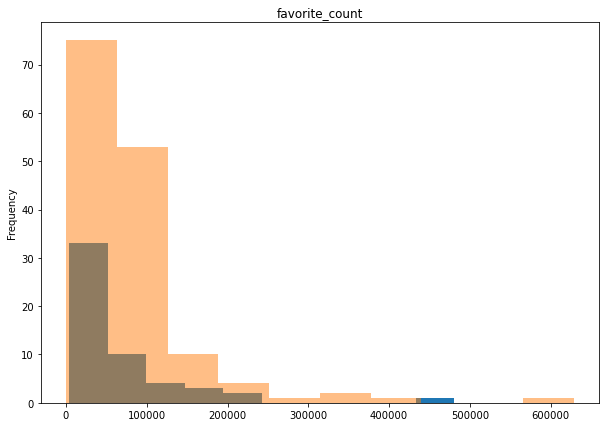

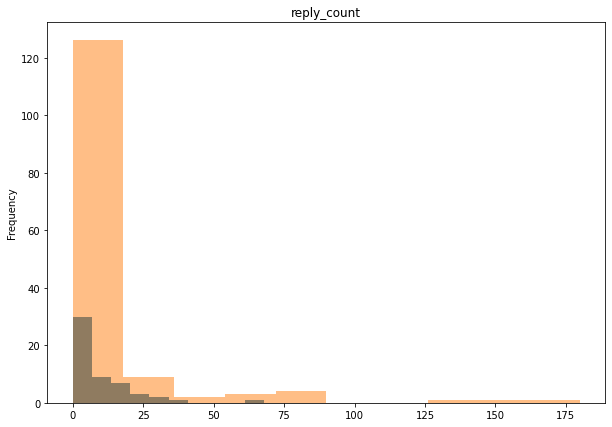

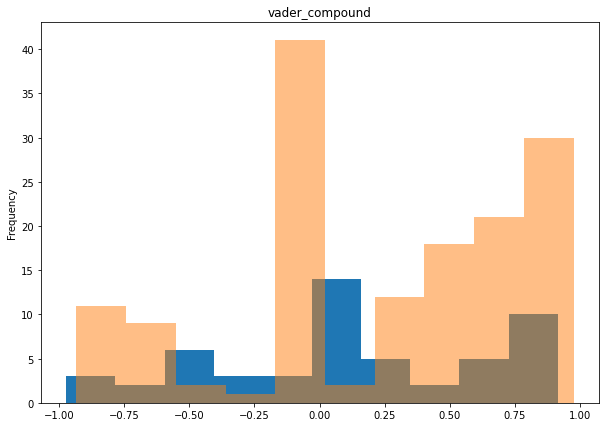

In [88]:
hist_plots(biden_1101, trump_1101)

In [99]:
def boxplots(df):
    for col in ['favorite_count', 'reply_count', 'retweet_count', 'afinn_score', 'vader_compound']:
        if col in ['favorite_count', 'afinn_score', 'vader_compound']:
            df = df[df.text != '']
        plt.figure(figsize=(12,8))
        sns.boxplot(x = 'candidate', y = col, data = df, order=['Biden', 'Trump'])
        plt.show()

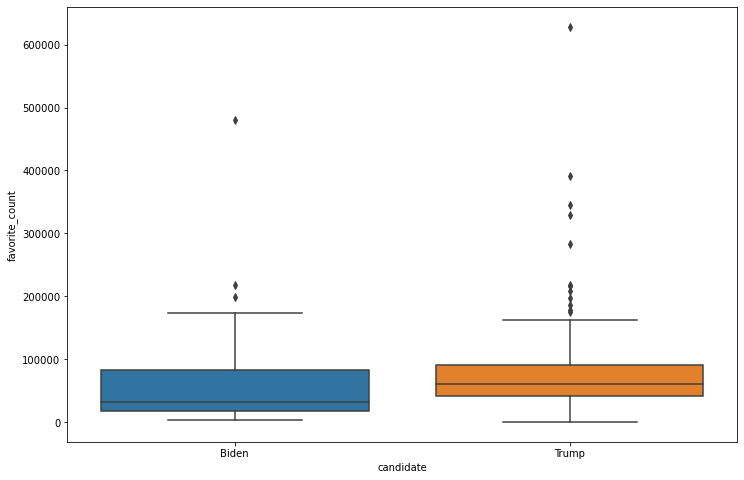

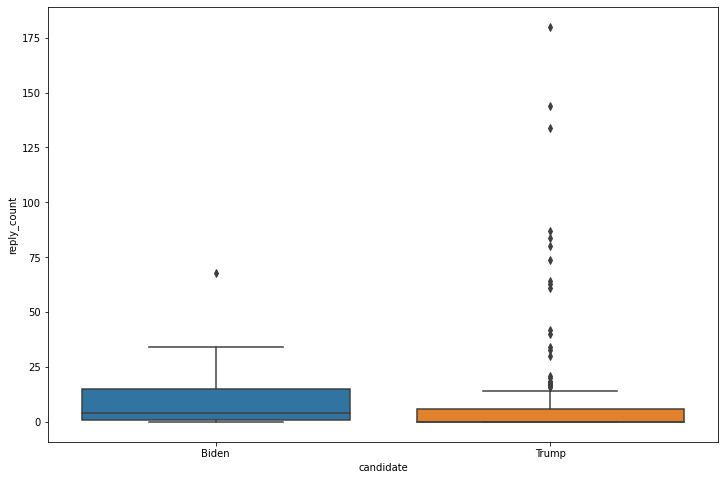

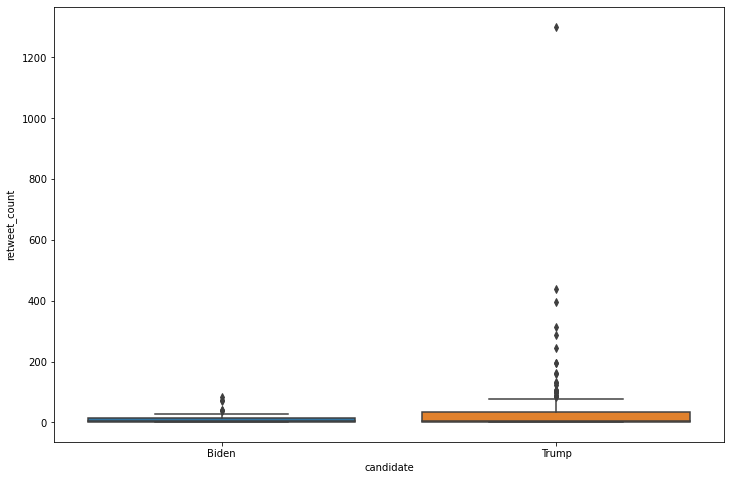

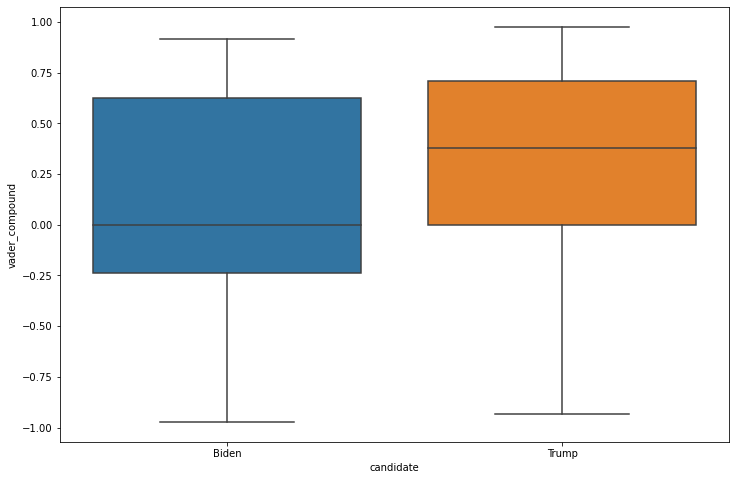

In [100]:
# tbdf_tweets_1101.boxplot(by='candidate', column=['favorite_count'], grid=False, figsize=(10, 7))
# plt.figure(figsize=(10,7))
# sns.boxplot(x = 'candidate', y = 'favorite_count', data = tbdf_tweets_1101, order=['Biden', 'Trump'])
# plt.show()

boxplots(tbdf_tweets_1101)

# Analyzing a week of data

November 1 - November 7

In [126]:
file_obj_week = file_objs_lst[1:8]
file_obj_week.reverse()
tbdf_1101_1107 = pd.DataFrame()
mentions_1101_1107 = pd.DataFrame()
for i, file_obj in enumerate(file_obj_week):
    if i == 0:
        tweets = tweets_1101
    else:
        tweets = gdrive_quickstart.download_pkl_file(DRIVE, file_obj, print_status=True)
    tbdf_tweets, mentions_lst = build_tb_tweets(tweets)
    
    tbdf_tweets['day'] = i + 1
    tbdf_1101_1107 = tbdf_1101_1107.append(tbdf_tweets, ignore_index=True, sort=False)
    
    mentions_df = pd.DataFrame(mentions_lst)
    mentions_df['day'] = i + 1
    mentions_1101_1107 = mentions_1101_1107.append(mentions_df, ignore_index=True, sort=False)
    
    print(f"Day {i + 1} finished")

Day 1 finished
Download 37%.
Download 75%.
Download 100%.
Day 2 finished
Download 39%.
Download 79%.
Download 100%.
Day 3 finished
Download 38%.
Download 76%.
Download 100%.
Day 4 finished
Download 40%.
Download 80%.
Download 100%.
Day 5 finished
Download 39%.
Download 78%.
Download 100%.
Day 6 finished
Download 37%.
Download 75%.
Download 100%.
Day 7 finished


In [278]:
tbdf_s_1101_1107.sort_values(by='afinn_score').head(10)

# df.sort_values(by='col1', ascending=False)

candidate  favorite_count  reply_count  retweet_count  \
694      Biden          154204            0              1   
1094     Trump          236135            1              1   
477      Trump           44836           16             20   
729      Trump          235569           32             71   
448      Biden           65350           33             10   
33       Biden           39581           32             20   
1396     Biden           70328            0              1   
1547     Biden           70332            0              1   
826      Trump           39109            2             15   
1101     Trump          218736            0              1   

                                                                                                                                                                                                                                                                                      text  \
694   Today marks 22 years since Matthew Shepard passed away after a brutal anti-gay hate crime. Over two decades later, violence against LGBTQ+ Americans is at an all-time high. As president, I'll strengthen our hate crimes laws and make clear that bigotry has no place in America.   
1094     Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.   
477      Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.   
729      Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.   
448                 It’s long past time we take action to end the scourge of gun violence in America.\n\nAs president, I’ll ban assault weapons and high-capacity magazines, implement universal background checks, and enact other common-sense reforms to end our gun violence epidemic.   
33                  It’s long past time we take action to end the scourge of gun violence in America.\n\nAs president, I’ll ban assault weapons and high-capacity magazines, implement universal background checks, and enact other common-sense reforms to end our gun violence epidemic.   
1396                It’s long past time we take action to end the scourge of gun violence in America.\n\nAs president, I’ll ban assault weapons and high-capacity magazines, implement universal background checks, and enact other common-sense reforms to end our gun violence epidemic.   
1547                It’s long past time we take action to end the scourge of gun violence in America.\n\nAs president, I’ll ban assault weapons and high-capacity magazines, implement universal background checks, and enact other common-sense reforms to end our gun violence epidemic.   
826                 Joe Biden’s plan to BAN FRACKING is an Economic DEATH SENTENCE for Pennsylvania. A vote for Biden is a vote to Ban Fracking, Outlaw Mining, explode energy costs, and totally DESTROY Pennsylvania. Get out tomorrow and VOTE #TrumpPence2020! https://t.co/niFJw558En   
1101    Crazy Joe Biden is trying to act like a tough guy. Actually, he is weak, both mentally and physically, and yet he threatens me, for the second time, with physical assault. He doesn’t know me, but he would go down fast and hard, crying all the way. Don’t threaten people Joe!   

                 tweet_id  afinn_score  vader_compound  day  
694   1315784310016761857        -17.0         -0.9545    2  
1094  1323481349030879232        -13.0         -0.9

In [279]:
tbdf_s_1101_1107.sort_values(by='vader_compound').head(10)

candidate  favorite_count  reply_count  retweet_count  \
1094     Trump          236135            1              1   
729      Trump          235569           32             71   
477      Trump           44836           16             20   
1396     Biden           70328            0              1   
448      Biden           65350           33             10   
1547     Biden           70332            0              1   
33       Biden           39581           32             20   
694      Biden          154204            0              1   
460      Trump           32616           13             60   
826      Trump           39109            2             15   

                                                                                                                                                                                                                                                                                      text  \
1094     Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.   
729      Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.   
477      Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.   
1396                It’s long past time we take action to end the scourge of gun violence in America.\n\nAs president, I’ll ban assault weapons and high-capacity magazines, implement universal background checks, and enact other common-sense reforms to end our gun violence epidemic.   
448                 It’s long past time we take action to end the scourge of gun violence in America.\n\nAs president, I’ll ban assault weapons and high-capacity magazines, implement universal background checks, and enact other common-sense reforms to end our gun violence epidemic.   
1547                It’s long past time we take action to end the scourge of gun violence in America.\n\nAs president, I’ll ban assault weapons and high-capacity magazines, implement universal background checks, and enact other common-sense reforms to end our gun violence epidemic.   
33                  It’s long past time we take action to end the scourge of gun violence in America.\n\nAs president, I’ll ban assault weapons and high-capacity magazines, implement universal background checks, and enact other common-sense reforms to end our gun violence epidemic.   
694   Today marks 22 years since Matthew Shepard passed away after a brutal anti-gay hate crime. Over two decades later, violence against LGBTQ+ Americans is at an all-time high. As president, I'll strengthen our hate crimes laws and make clear that bigotry has no place in America.   
460                 Joe Biden’s plan to BAN FRACKING is an Economic DEATH SENTENCE for Pennsylvania. A vote for Biden is a vote to Ban Fracking, Outlaw Mining, explode energy costs, and totally DESTROY Pennsylvania. Get out tomorrow and VOTE #TrumpPence2020! https://t.co/niFJw558En   
826                 Joe Biden’s plan to BAN FRACKING is an Economic DEATH SENTENCE for Pennsylvania. A vote for Biden is a vote to Ban Fracking, Outlaw Mining, explode energy costs, and totally DESTROY Pennsylvania. Get out tomorrow and VOTE #TrumpPence2020! https://t.co/niFJw558En   

                 tweet_id  afinn_score  vader_compound  day  
1094  1323481349030879232        -13.0         -0.9810    4  
729   1323481349030879232        -13.0         -0.9

In [280]:
tbdf_s_1101_1107.sort_values(by='afinn_score', ascending=False).head(10)

candidate  favorite_count  reply_count  retweet_count  \
288      Trump           75387            0              1   
268      Trump           61401            1              2   
435      Trump           37124           21             79   
1462     Trump           92672            0              2   
279      Trump          216004            0              1   
788      Trump           89191            5            126   
1069     Trump           91855            1              2   
271      Trump           54313            1              7   
5        Trump           40070            0              1   
140      Trump           88134            7             18   

                                                                                                                                                                                                                                                                                                                      text  \
288                              For half a century, Joe Biden has been outsourcing your jobs, opening your borders, and sacrificing American blood and treasure in endless foreign wars. Joe Biden is a corrupt politician—If Biden Wins, China Wins. When We Win, Florida Wins—and America Wins! https://t.co/UdqQqmxvL7   
268   Joe Biden is a corrupt politician—the Biden family is looking more &amp; more like a crime family. They took millions of $$ from the Chinese Communists, while Vice President Biden shipped Michigan jobs to China. If Biden wins, China Wins. When we win, Michigan wins, and AMERICA wins! https://t.co/YpnjH8838X   
435                                                                                                                                                                                         I am asking you to go VOTE for your favorite president, we still have work to do! Let’s WIN, WIN, WIN! https://t.co/ysLmOS689V   
1462                                                                                                                                                                                        I am asking you to go VOTE for your favorite president, we still have work to do! Let’s WIN, WIN, WIN! https://t.co/ysLmOS689V   
279                      HUGE win today for the United States and for peace in the world. Sudan has agreed to a peace and normalization agreement with Israel! With the United Arab Emirates and Bahrain, that’s THREE Arab countries to have done so in only a matter of weeks. More will follow! https://t.co/UHB8H6oaZc   
788                                                                                                                                                                                         I am asking you to go VOTE for your favorite president, we still have work to do! Let’s WIN, WIN, WIN! https://t.co/ysLmOS689V   
1069                                                                                                                                                                                        I am asking you to go VOTE for your favorite president, we still have work to do! Let’s WIN, WIN, WIN! https://t.co/ysLmOS689V   
271        Our ECONOMY is now surging back faster, better, bigger and stronger than any nation on earth. We just had the best quarter of ECONOMIC GROWTH EVER recorded - a 33.1% increase, and next year will be the GREATEST ECONOMIC YEAR in the history of our Country! https://t.co/gsFSghkmdM https://t.co/Kbyl4zVUWM   
5                                                    .@LouieGohmertTX1 is a Fantastic Republican from the Great State of Texas! He fully supports our #MAGA and #KAG Agenda, Border WALL, Military, Vets, and your Second Amendment. Louie is my friend and has my Complete and Total Endorsement! https://t.co/7MWH000IbI   
140                                                                                                                                           

In [281]:
tbdf_s_1101_1107.sort_values(by='vader_compound', ascending=False).head(10)

candidate  favorite_count  reply_count  retweet_count  \
279      Trump          216004            0              1   
1676     Biden          301674           14             17   
1496     Biden          148618            8              8   
271      Trump           54313            1              7   
1714     Trump           67493            0              1   
1247     Trump           67501            0              1   
845      Trump           60130            3              2   
487      Trump           55348           28             40   
435      Trump           37124           21             79   
1462     Trump           92672            0              2   

                                                                                                                                                                                                                                                                                                                      text  \
279                      HUGE win today for the United States and for peace in the world. Sudan has agreed to a peace and normalization agreement with Israel! With the United Arab Emirates and Bahrain, that’s THREE Arab countries to have done so in only a matter of weeks. More will follow! https://t.co/UHB8H6oaZc   
1676                                                                                                      I pledge to be a President who seeks not to divide, but to unify.\n\nWho doesn’t see Red and Blue states, but a United States.\n\nAnd who will work with all my heart to win the confidence of the whole people.   
1496                                                                                                      I pledge to be a President who seeks not to divide, but to unify.\n\nWho doesn’t see Red and Blue states, but a United States.\n\nAnd who will work with all my heart to win the confidence of the whole people.   
271        Our ECONOMY is now surging back faster, better, bigger and stronger than any nation on earth. We just had the best quarter of ECONOMIC GROWTH EVER recorded - a 33.1% increase, and next year will be the GREATEST ECONOMIC YEAR in the history of our Country! https://t.co/gsFSghkmdM https://t.co/Kbyl4zVUWM   
1714  With your VOTE, we will continue to cut your taxes and regs, support our police, support our military, protect your 2A, defend religious liberty &amp; ensure more products are proudly stamped MADE IN THE USA! Next year will be the greatest economic year in the history of our Country! https://t.co/xiOTYudYic   
1247  With your VOTE, we will continue to cut your taxes and regs, support our police, support our military, protect your 2A, defend religious liberty &amp; ensure more products are proudly stamped MADE IN THE USA! Next year will be the greatest economic year in the history of our Country! https://t.co/xiOTYudYic   
845   With your VOTE, we will continue to cut your taxes and regs, support our police, support our military, protect your 2A, defend religious liberty &amp; ensure more products are proudly stamped MADE IN THE USA! Next year will be the greatest economic year in the history of our Country! https://t.co/xiOTYudYic   
487   With your VOTE, we will continue to cut your taxes and regs, support our police, support our military, protect your 2A, defend religious liberty &amp; ensure more products are proudly stamped MADE IN THE USA! Next year will be the greatest economic year in the history of our Country! https://t.co/xiOTYudYic   
435                                                                                                                                                                                         I am asking you to go VOTE for your favorite president, we still have work to do! Let’s WIN, WIN, WIN! https://t.co/ysLmOS689V   
1462                                                                                                                                          

In [282]:
tbdf_s_1101_1107[tbdf_s_1101_1107.candidate == 'Biden'].sort_values(by='vader_compound', ascending=False).head(5)

candidate  favorite_count  reply_count  retweet_count  \
1496     Biden          148618            8              8   
1676     Biden          301674           14             17   
482      Biden           25369            5             12   
1016     Biden          158638            0              1   
451      Biden           25038           21             13   

                                                                                                                                                                                                                                                                text  \
1496                                                I pledge to be a President who seeks not to divide, but to unify.\n\nWho doesn’t see Red and Blue states, but a United States.\n\nAnd who will work with all my heart to win the confidence of the whole people.   
1676                                                I pledge to be a President who seeks not to divide, but to unify.\n\nWho doesn’t see Red and Blue states, but a United States.\n\nAnd who will work with all my heart to win the confidence of the whole people.   
482   No one fights harder for the people of Alabama than my friend, @DougJones. He's a Senator with a big heart and he's never afraid to fight for what's right.\n\nDoug is in a tight race and needs your help to win on Tuesday. Chip in: https://t.co/jwBbBDNZfH   
1016                                     Here’s my promise to you: If I have the honor of serving as the next commander in chief, I will ensure that our American heroes know that I will have their back and honor their sacrifice. Always. https://t.co/wMFHHscD51   
451               My faith has been my anchor through highs and lows –– a guiding light that taught me the values of honesty, decency, and treating others with respect.\n\nAs president, it will continue to serve as a source of strength. https://t.co/wIVS8Uga2d   

                 tweet_id  afinn_score  vader_compound  day  
1496  1325253203022241792          7.0          0.9688    7  
1676  1325253203022241792          7.0          0.9688    8  
482   1323122502751653888          4.0          0.9446    2  
1016  1301697991481458688          8.0          0.9274    4  
451   1323267619416399872          5.0          0.9217    2

In [333]:
def tbdf_boxplots(df, outliers):
    for col in ['favorite_count', 'reply_count', 'retweet_count', 'afinn_score', 'vader_compound']:
        if col in ['favorite_count', 'afinn_score', 'vader_compound']:
            df = df[df.text != '']
        plt.figure(figsize=(12,8))
        sns.boxplot(x='day', y=col, hue='candidate', data=df, hue_order=['Biden', 'Trump'], showfliers=outliers)
        plt.show()
        

def tbdf_lineplots(df):
    for col in ['favorite_count', 'reply_count', 'retweet_count', 'afinn_score', 'vader_compound']:
        if col in ['favorite_count', 'afinn_score', 'vader_compound']:
            df = df[df.text != '']
        plt.figure(figsize=(12,8))
        sns.lineplot(x='day', y=col, hue='candidate', data=df, hue_order=['Biden', 'Trump'])
        plt.show()
        
        
def add_sentiment_cols(df):
    df['afinn_score'] = df['text'].apply(af.score)

    sentiment_vader = df['text'].apply(vader.polarity_scores)
    sentiment_v_df = pd.DataFrame(sentiment_vader.tolist())
    df['vader_compound'] = sentiment_v_df['compound']

    return df

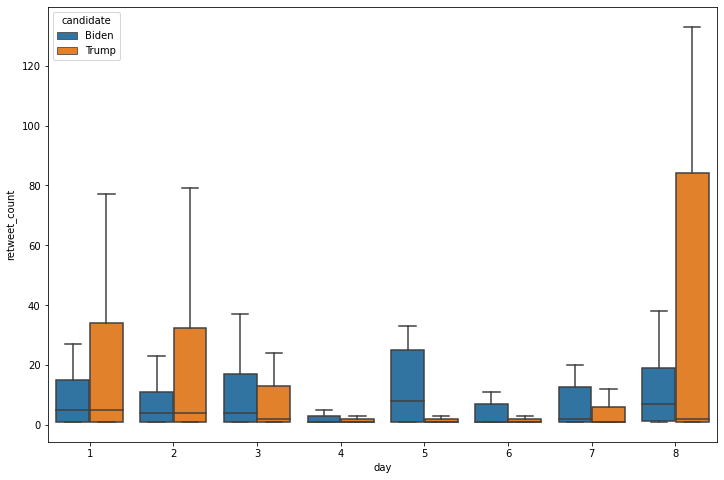

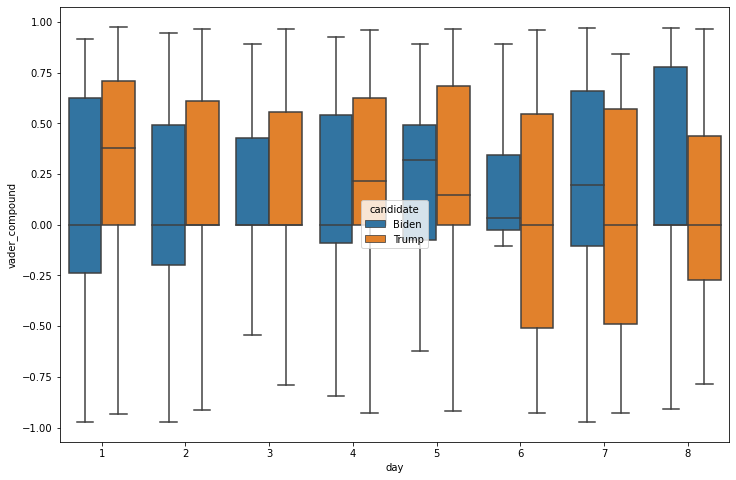

In [149]:
tbdf_s_1101_1107 = add_sentiment_cols(tbdf_1101_1107)

tbdf_boxplots(tbdf_s_1101_1107, outliers=False)

Notice:
- Trump's favorites seem pretty consistent
- Biden's favorites really fluctuate (and increase) as the election stretches on


- Biden seems to consistently have more replies (which is interesting if we typically correlate that with a negative sentiment)


- During the true "election," Biden has more retweets
- Trump retweets blow up the day after Biden becomes President-elect (looks like he was retweeting A LOT)


- Both candidates tweets are generally pretty positive (up through the 5th)
- Once the 6th hits (and Biden is more concretely pulling ahead), Trump's tweets become noticeably more negative (visible in both afinn and vader sentiment analysis)

In [332]:
def mentions_barplots(df):
    for col in ['mention_count', 'retweet_count', 'reply_count', 'ratio1', 'ratio2', 'ratio3']:
        plt.figure(figsize=(12,8))
        
        if col == 'ratio1':
            sns.barplot(x='day', y=(df.retweet_count / df.mention_count), hue='candidate', data=df, 
                        hue_order=['Biden', 'Trump']).set_title("retweet / mentions")
        elif col == 'ratio2':
            sns.barplot(x='day', y=(df.reply_count / df.mention_count), hue='candidate', data=df, 
                        hue_order=['Biden', 'Trump']).set_title("reply / mentions")
        elif col == 'ratio3':
            sns.barplot(x='day', y=(df.reply_count / df.retweet_count), hue='candidate', data=df, 
                        hue_order=['Biden', 'Trump']).set_title("reply / retweet")
        else:
            sns.barplot(x='day', y=col, hue='candidate', data=df, hue_order=['Biden', 'Trump'])
        plt.show()
        
        
def mentions_lineplots(df):
    for col in ['mention_count', 'retweet_count', 'reply_count', 'ratio1', 'ratio2', 'ratio3']:
        plt.figure(figsize=(12,8))
        
        if col == 'ratio1':
            sns.lineplot(x='day', y=(df.retweet_count / df.mention_count), hue='candidate', data=df, 
                         hue_order=['Biden', 'Trump']).set_title("retweet / mentions")
        elif col == 'ratio2':
            sns.lineplot(x='day', y=(df.reply_count / df.mention_count), hue='candidate', data=df, 
                         hue_order=['Biden', 'Trump']).set_title("reply / mentions")
        elif col == 'ratio3':
            sns.lineplot(x='day', y=(df.reply_count / df.retweet_count), hue='candidate', data=df, 
                         hue_order=['Biden', 'Trump']).set_title("reply / retweet")
        else:
            sns.lineplot(x='day', y=col, hue='candidate', data=df, hue_order=['Biden', 'Trump'])
        plt.show()

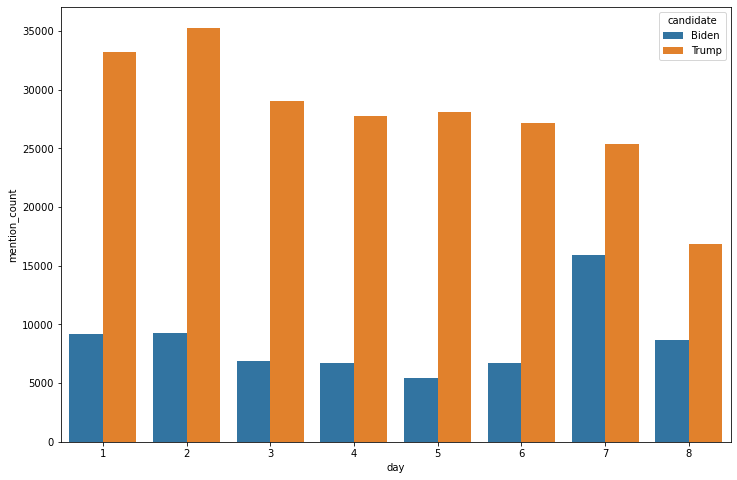

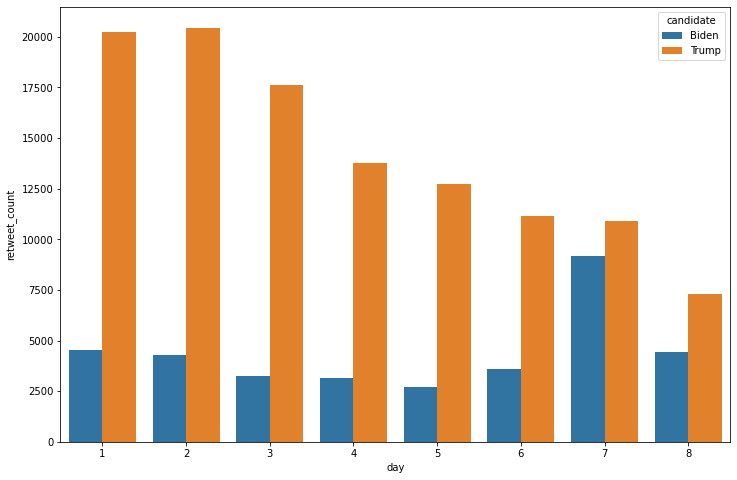

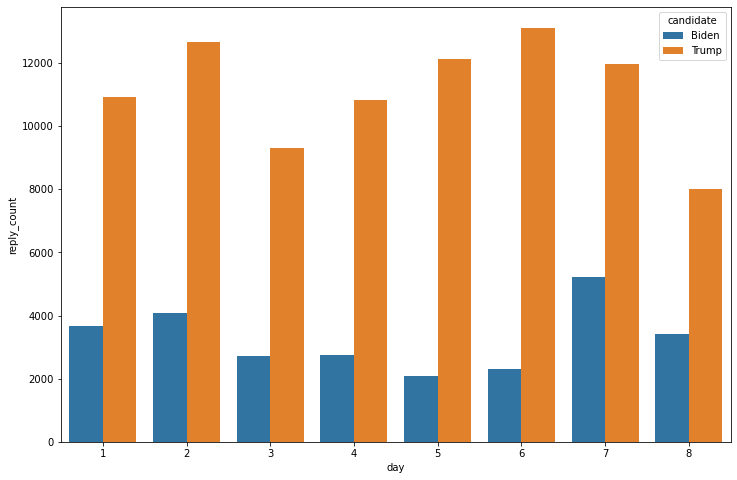

In [175]:
mentions_barplots(mentions_1101_1107)

Notice:
- Trump's mentions from retweets steadily decreases as the week progresses
- Biden's mentions from retweets is pretty constant, but it decreases, then spikes when he is announced as President-elect (mimics his overall mentions)


- Biden's proportion of mentions from retweets increases as the week progresses while Trump's decrease
    - If we consider that a retweet is a positive sentiment, it shows momentum towards Biden and away from Trump
- We see a similar (but opposite) trend with replies
    - If we consider that a reply is more so a negative sentiment, it corroborates the above sentiment

In [186]:
biden_1101_1107 = tbdf_1101_1107[tbdf_1101_1107.candidate == "Biden"]
trump_1101_1107 = tbdf_1101_1107[tbdf_1101_1107.candidate == "Trump"]

def sentiment_summary_stats(df):
    df = df[df.text != '']
    df_len = len(df)
    for col in ['afinn_score', 'vader_compound']:
        df_pos = sum(df[col] > 0)
        df_neu = sum(df[col] == 0)
        df_neg = sum(df[col] < 0)
        df_mean = np.mean(df[col])
        df_sum = sum(df[col])
        print(f"{col} summary:")
        print(f"Total tweets: {df_len} | positive: {df_pos} | neutral: {df_neu} | negative: {df_neg}")
        print(f"mean score: {df_mean} | sum: {df_sum}")
        print("*****************************************")

In [188]:
print("Biden")
sentiment_summary_stats(biden_1101_1107)
print("\nTrump")
sentiment_summary_stats(trump_1101_1107)

Biden
afinn_score summary:
Total tweets: 290 | positive: 132 | neutral: 83 | negative: 75
mean score: 0.8241379310344827 | sum: 239.0
*****************************************
vader_compound summary:
Total tweets: 290 | positive: 135 | neutral: 79 | negative: 76
mean score: 0.14491068965517243 | sum: 42.02409999999999
*****************************************

Trump
afinn_score summary:
Total tweets: 660 | positive: 282 | neutral: 221 | negative: 157
mean score: 0.7984848484848485 | sum: 527.0
*****************************************
vader_compound summary:
Total tweets: 660 | positive: 323 | neutral: 204 | negative: 133
mean score: 0.1726481818181818 | sum: 113.94780000000013
*****************************************


In [375]:
def sentiment_summary_stats_by_day(df, print_flag=False):
    df = df[df.text != '']
    rows = []
    for col in ['afinn_score', 'vader_compound']:
        for i in range(df.day.min(), df.day.max() + 1):
            df_day = df[df.day == i]
            df_len = len(df_day)
            df_pos = sum(df_day[col] > 0)
            df_neu = sum(df_day[col] == 0)
            df_neg = sum(df_day[col] < 0)
            df_mean = np.mean(df_day[col])
            df_sum = sum(df_day[col])
            
            # Add to row_dict
            row_dict = {'sentiment_type' : col, 'day' : i, 'tweet_count' : df_len, 'pos_count' : df_pos, 
                        'neu_count' : df_neu, 'neg_count' : df_neg, 'mean_sentiment' : df_mean, 'sum_score' : df_sum}
            rows.append(row_dict)
            
            if print_flag:
                print(f"Day {i} - {col} summary:")
                print(f"Total tweets: {df_len} | positive: {df_pos} | neutral: {df_neu} | negative: {df_neg}")
                print(f"mean score: {df_mean} | sum: {df_sum}")
                print("*****************************************")
        if print_flag:
            print()
        
    return pd.DataFrame(rows)

In [200]:
print("Biden")
biden_sentiment_1101_1107 = sentiment_summary_stats_by_day(biden_1101_1107)
print("\nTrump")
trump_sentiment_1101_1107 = sentiment_summary_stats_by_day(trump_1101_1107)

Biden
Day 1 - afinn_score summary:
Total tweets: 53 | positive: 22 | neutral: 13 | negative: 18
mean score: 0.4716981132075472 | sum: 25.0
*****************************************
Day 2 - afinn_score summary:
Total tweets: 63 | positive: 25 | neutral: 19 | negative: 19
mean score: 0.1746031746031746 | sum: 11.0
*****************************************
Day 3 - afinn_score summary:
Total tweets: 51 | positive: 20 | neutral: 22 | negative: 9
mean score: 0.7843137254901961 | sum: 40.0
*****************************************
Day 4 - afinn_score summary:
Total tweets: 35 | positive: 18 | neutral: 9 | negative: 8
mean score: 1.3714285714285714 | sum: 48.0
*****************************************
Day 5 - afinn_score summary:
Total tweets: 21 | positive: 12 | neutral: 4 | negative: 5
mean score: 1.5714285714285714 | sum: 33.0
*****************************************
Day 6 - afinn_score summary:
Total tweets: 16 | positive: 9 | neutral: 4 | negative: 3
mean score: 1.0 | sum: 16.0
*********

In [208]:
biden_sentimentdf_1101_1107 = pd.DataFrame(biden_sentiment_1101_1107)
biden_sentimentdf_1101_1107['candidate'] = "Biden"
trump_sentimentdf_1101_1107 = pd.DataFrame(trump_sentiment_1101_1107)
trump_sentimentdf_1101_1107['candidate'] = "Trump"

sentimentdf_1101_1107 = biden_sentimentdf_1101_1107.append(trump_sentimentdf_1101_1107, ignore_index=True, sort=False)

In [210]:
sentimentdf_1101_1107

day  mean_sentiment  neg_count  neu_count  pos_count  sentiment_type  \
0     1        0.471698         18         13         22     afinn_score   
1     2        0.174603         19         19         25     afinn_score   
2     3        0.784314          9         22         20     afinn_score   
3     4        1.371429          8          9         18     afinn_score   
4     5        1.571429          5          4         12     afinn_score   
5     6        1.000000          3          4          9     afinn_score   
6     7        1.093750          9          6         17     afinn_score   
7     8        1.631579          4          6          9     afinn_score   
8     1        0.100736         17         12         24  vader_compound   
9     2        0.112621         18         17         28  vader_compound   
10    3        0.153608          8         21         22  vader_compound   
11    4        0.178926         10          9         16  vader_compound   
12    5        0.200710          6          4         11  vader_compound   
13    6        0.079331          4          4          8  vader_compound   
14    7        0.182125          9          6         17  vader_compound   
15    8        0.220074          4          6          9  vader_compound   
16    1        1.666667         29         45         73     afinn_score   
17    2        0.668919         33         57         58     afinn_score   
18    3        0.889908         19         42         48     afinn_score   
19    4        0.901408         13         29         29     afinn_score   
20    5        0.625000         16         18         30     afinn_score   
21    6       -0.229508         24         16         21     afinn_score   
22    7       -0.382353         14          8         12     afinn_score   
23    8        0.346154          9          6         11     afinn_score   
24    1        0.258554         24         40         83  vader_compound   
25    2        0.157574         27         51         70  vader_compound   
26    3        0.173980         19         38         52  vader_compound   
27    4        0.242655          8         26         37  vader_compound   
28    5        0.179716         13         18         33  vader_compound   
29    6        0.011379         22         17         22  vader_compound   
30    7        0.034538         12          7         15  vader_compound   
31    8        0.117569          8          7         11  vader_compound   

    sum_score  tweet_count candidate  
0     25.0000           53     Biden  
1     11.0000           63     Biden  
2     40.0000           51     Biden  
3     48.0000           35     Biden  
4     33.0000           21     Biden  
5     16.0000           16     Biden  
6     35.0000           32     Biden  
7     31.0000           19     Biden  
8      5.3390           53     Biden  
9      7.0951           63     Biden  
10     7.8340           51     Biden  
11     6.2624           35     Biden  
12     4.2149           21     Biden  
13     1.2693           16     Biden  
14     5.8280           32     Biden  
15     4.1814           19     Biden  
16   245.0000          147     Trump  
17    99.0000          148     Trump  
18    97.0000          109     Trump  
19    64.0000           71     Trump  
20    40.0000           64     Trump  
21   -14.0000           61     Trump  
22   -13.0000           34     Trump  
23     9.0000           26     Trump  
24    38.0075          147     Trump  
25    23.3210          148     Trump  
26    18.9638          109     Trump  
27    17.2285           71     Trump  
28    11.5018           64     Trump  
29     0.6941           61     Trump  
30     1.1743           34     Trump  
31     3.0568           26     Trump

In [369]:
def melt_sentiment_df(df, sentiment_type, candidate):
    df_melt = df[df.sentiment_type == sentiment_type][df.candidate == candidate]
    df_melt = pd.melt(df_melt[['day', 'neg_count', 'neu_count', 'pos_count']], 
                      id_vars="day", var_name="sentiment_category", value_name="count")
    return df_melt


def sentiment_barplot(df, sentiment_type, candidate):
    df_melt = melt_sentiment_df(df, sentiment_type, candidate)

    g = sns.catplot(x='day', y='count', hue='sentiment_category', data=df_melt, kind='bar', height=10, aspect=1.5, 
                    hue_order=['pos_count', 'neu_count', 'neg_count'], palette=['darkgreen', 'goldenrod', 'firebrick'])
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle(f"{candidate} {sentiment_type}")
    plt.show()
    
    
def sentiment_lineplot(df, sentiment_type, candidate):
    df = df[df.sentiment_type == sentiment_type][df.candidate == candidate].reset_index()
    
    ax = sns.lineplot(x="day", y='pos_count', data=df, color='green', legend='brief', label='Positive')
    sns.lineplot(x="day", y='neu_count', data=df, color='orange', ax=ax, legend='brief', label='Neutral')
    sns.lineplot(x="day", y='neg_count', data=df, color='red', ax=ax, legend='brief', label='Negative')

    plt.show()

In [368]:
sentiment_lineplot(sentimentdf_1101_1107, 'afinn_score', "Biden")

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


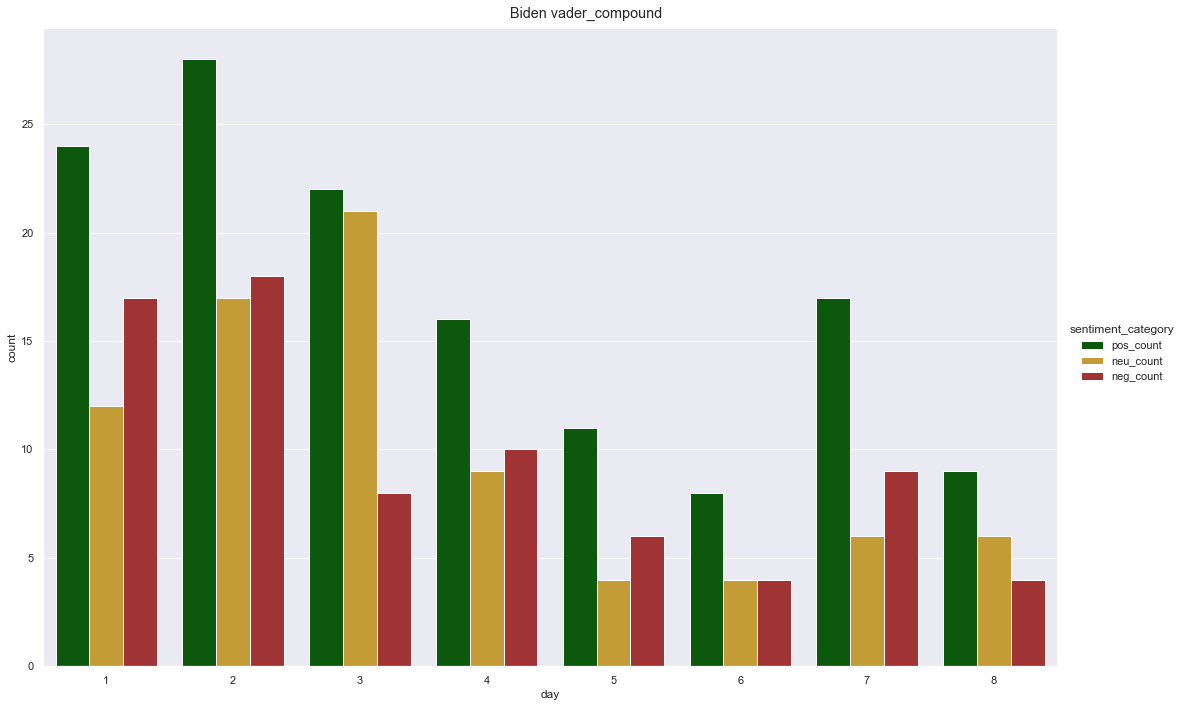

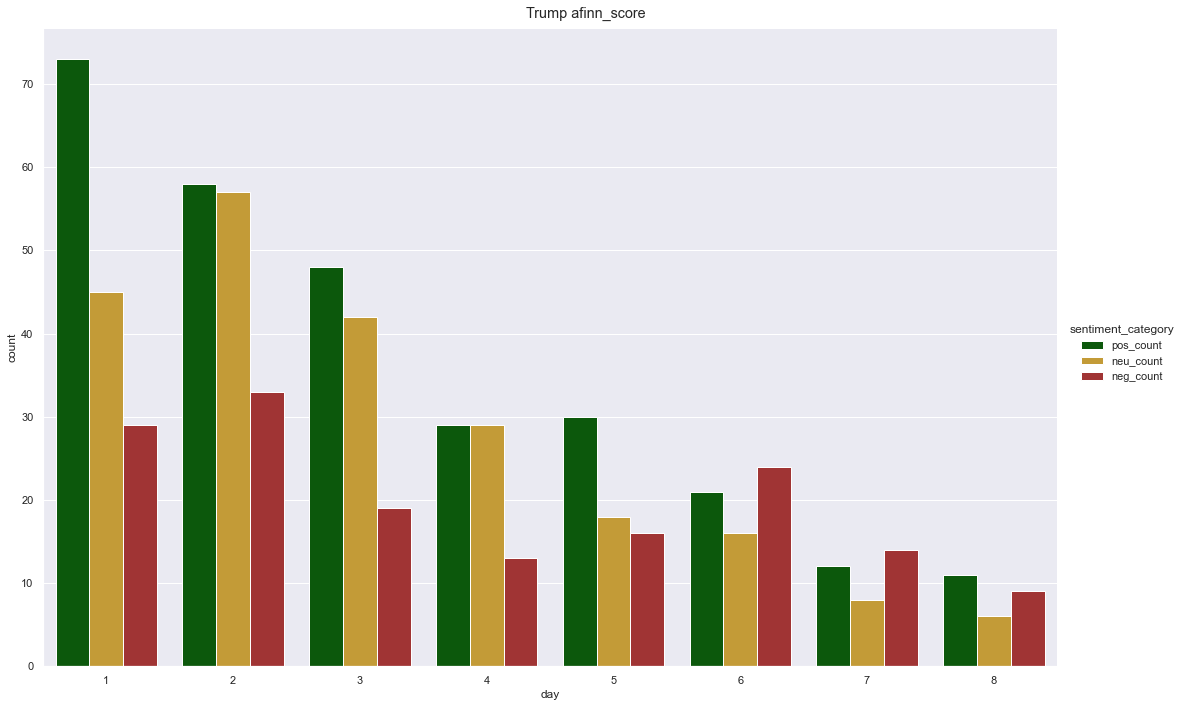

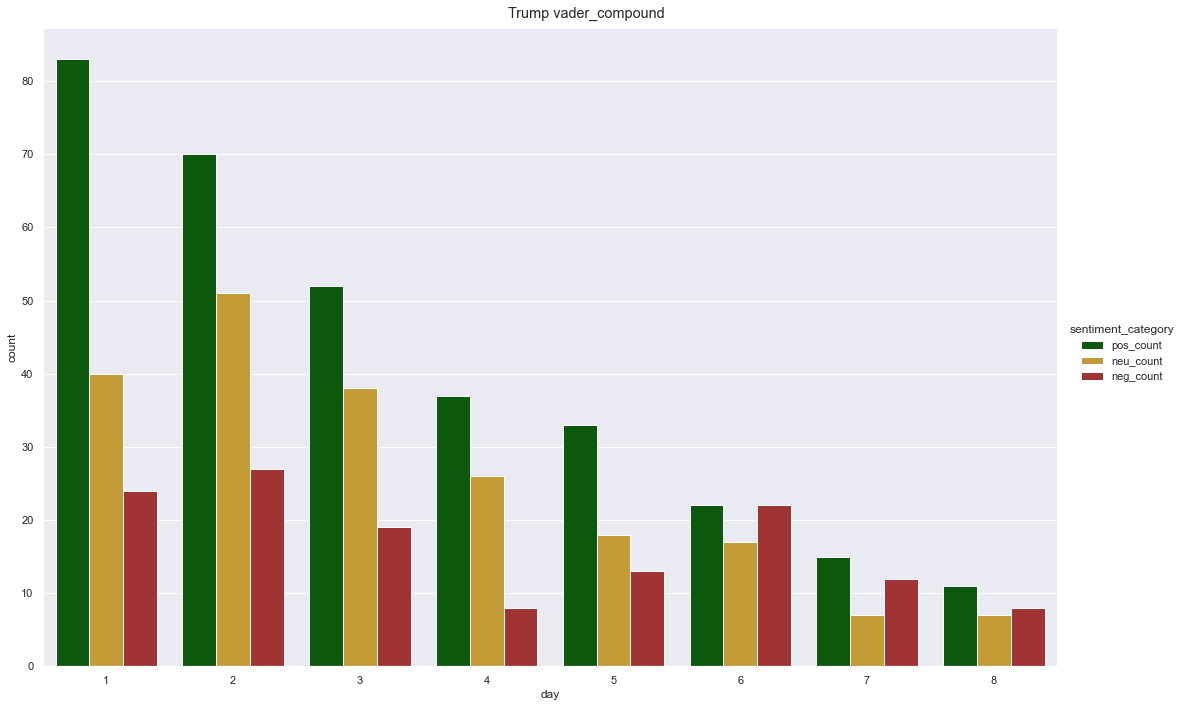

In [265]:
sentiment_barplot(sentimentdf_1101_1107, 'afinn_score', "Biden")
sentiment_barplot(sentimentdf_1101_1107, 'vader_compound', "Biden")

sentiment_barplot(sentimentdf_1101_1107, 'afinn_score', "Trump")
sentiment_barplot(sentimentdf_1101_1107, 'vader_compound', "Trump")

In [329]:
sns.set_style("whitegrid", {'axes.grid' : False})

def sentiment_mean_sum_barplots(df):
    for col in ['mean_sentiment', 'sum_score']:
        for s_type in ['afinn_score', 'vader_compound']:
            plt.figure(figsize=(12,8))
            sns.barplot(x='day', y=col, hue='candidate', data=df[df.sentiment_type == s_type], 
                        hue_order=['Biden', 'Trump']).set_title(f"{col} with {s_type}")
            plt.show()
            
            
def sentiment_mean_sum_lineplots(df):
    for col in ['mean_sentiment', 'sum_score']:
        for s_type in ['afinn_score', 'vader_compound']:
            plt.figure(figsize=(12,8))
            sns.lineplot(x='day', y=col, hue='candidate', data=df[df.sentiment_type == s_type], 
                         hue_order=['Biden', 'Trump']).set_title(f"{col} with {s_type}")
            plt.show()

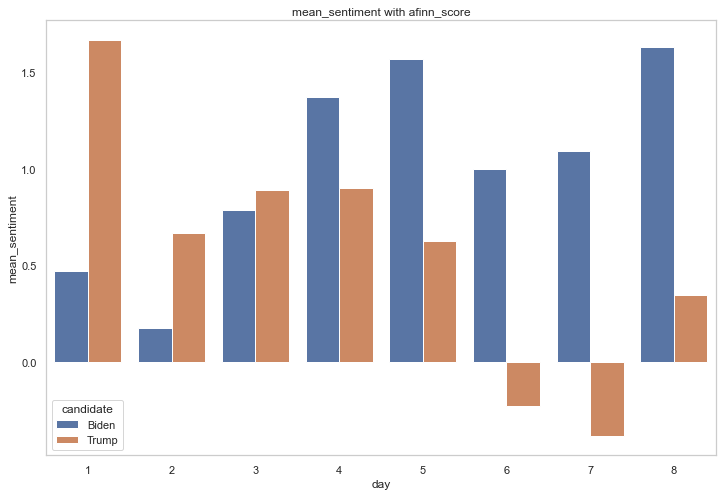

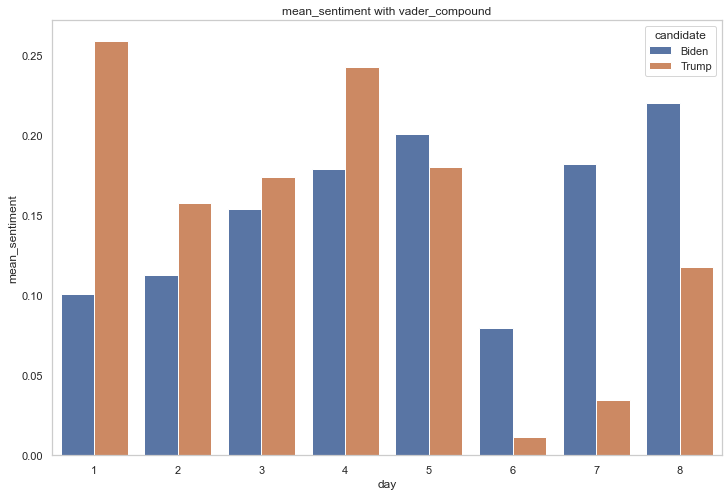

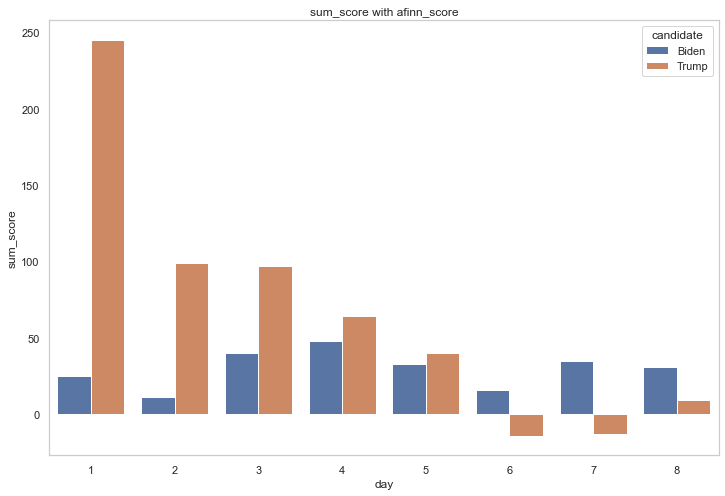

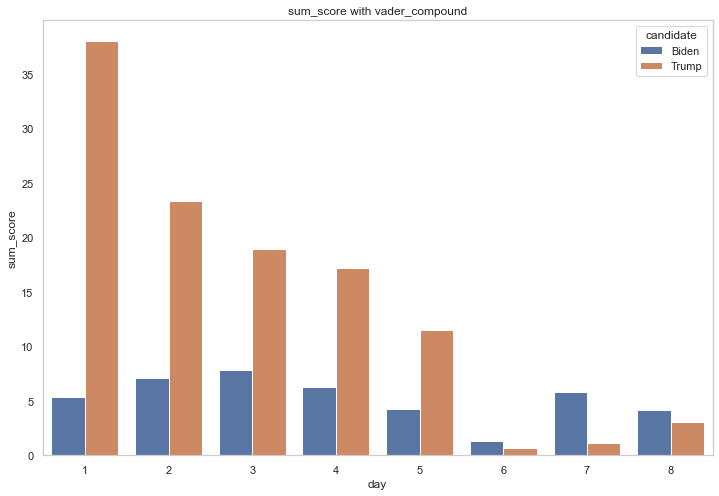

In [275]:
sentiment_mean_sum_barplots(sentimentdf_1101_1107)

# October - Present

In [327]:
def create_candidate_tweet_df(file_obj_df_lst):
    # Edit this so that only the dates are needed.
    file_obj_df_lst.reverse()
    tbdf = pd.DataFrame()
    mentions_tbdf = pd.DataFrame()
    for i, file_obj in enumerate(file_obj_df_lst):
        tweets = gdrive_quickstart.download_pkl_file(DRIVE, file_obj, print_status=True)
        tbdf_tweets, mentions_lst = build_tb_tweets(tweets)
    
        tbdf_tweets['day'] = i
        tbdf = tbdf.append(tbdf_tweets, ignore_index=True, sort=False)

        mentions_df = pd.DataFrame(mentions_lst)
        mentions_df['day'] = i
        mentions_tbdf = mentions_tbdf.append(mentions_df, ignore_index=True, sort=False)

        print(f"Day {i} finished")
        
    return tbdf, mentions_tbdf

In [328]:
tbdf_1001_1111, mentions_1001_1111 = create_candidate_tweet_df(file_objs_lst[:42])

Download 42%.
Download 84%.
Download 100%.
Day 0 finished
Download 43%.
Download 87%.
Download 100%.
Day 1 finished
Download 38%.
Download 76%.
Download 100%.
Day 2 finished
Download 38%.
Download 76%.
Download 100%.
Day 3 finished
Download 36%.
Download 72%.
Download 100%.
Day 4 finished
Download 38%.
Download 76%.
Download 100%.
Day 5 finished
Download 35%.
Download 71%.
Download 100%.
Day 6 finished
Download 36%.
Download 73%.
Download 100%.
Day 7 finished
Download 35%.
Download 70%.
Download 100%.
Day 8 finished
Download 35%.
Download 71%.
Download 100%.
Day 9 finished
Download 94%.
Download 100%.
Day 10 finished
Download 37%.
Download 74%.
Download 100%.
Day 11 finished
Download 37%.
Download 74%.
Download 100%.
Day 12 finished
Download 35%.
Download 71%.
Download 100%.
Day 13 finished
Download 37%.
Download 74%.
Download 100%.
Day 14 finished
Download 18%.
Download 37%.
Download 55%.
Download 74%.
Download 93%.
Download 100%.
Day 15 finished
Download 36%.
Download 72%.
Download 1

In [370]:
def tbdf_plots(tbdf, mentions_df):
    # Trump / Biden df plots
    tbdf_s = add_sentiment_cols(tbdf)
    tbdf_boxplots(tbdf_s, outliers=False)
    tbdf_lineplots(tbdf_s)
    
    
    # Mentions df plots
    mentions_barplots(mentions_df)
    mentions_lineplots(mentions_df)
    
    
    # Sentiment plots
    biden_df = tbdf_s[tbdf_s.candidate == "Biden"]
    trump_df = tbdf_s[tbdf_s.candidate == "Trump"]
    print("Biden")
    sentiment_summary_stats(biden_df)
    print("\nTrump")
    sentiment_summary_stats(trump_df)
    
    biden_df = sentiment_summary_stats_by_day(biden_df, False)
    biden_df['candidate'] = "Biden"
    trump_df = sentiment_summary_stats_by_day(trump_df, False)
    trump_df['candidate'] = "Trump"
    sentiment_df = biden_df.append(trump_df, ignore_index=True, sort=False)
    
    sentiment_barplot(sentiment_df, 'afinn_score', "Biden")
    sentiment_barplot(sentiment_df, 'vader_compound', "Biden")
    sentiment_lineplot(sentiment_df, 'afinn_score', "Biden")
    sentiment_lineplot(sentiment_df, 'vader_compound', "Biden")

    sentiment_barplot(sentiment_df, 'afinn_score', "Trump")
    sentiment_barplot(sentiment_df, 'vader_compound', "Trump")
    sentiment_lineplot(sentiment_df, 'afinn_score', "Trump")
    sentiment_lineplot(sentiment_df, 'vader_compound', "Trump")
    
    sentiment_mean_sum_barplots(sentiment_df)
    sentiment_mean_sum_lineplots(sentiment_df)

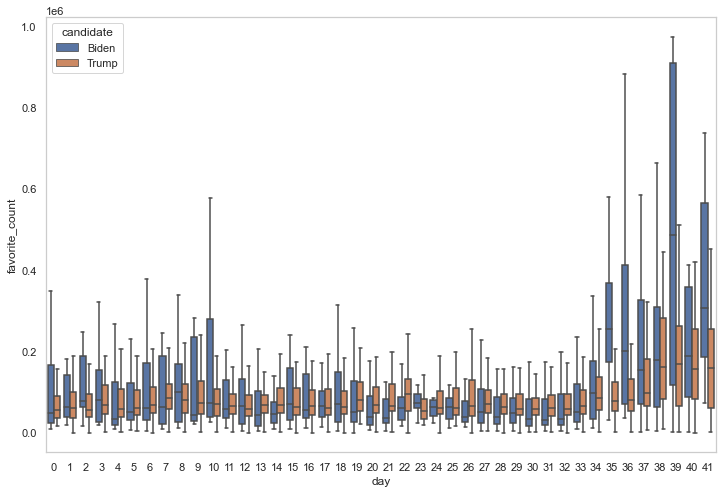

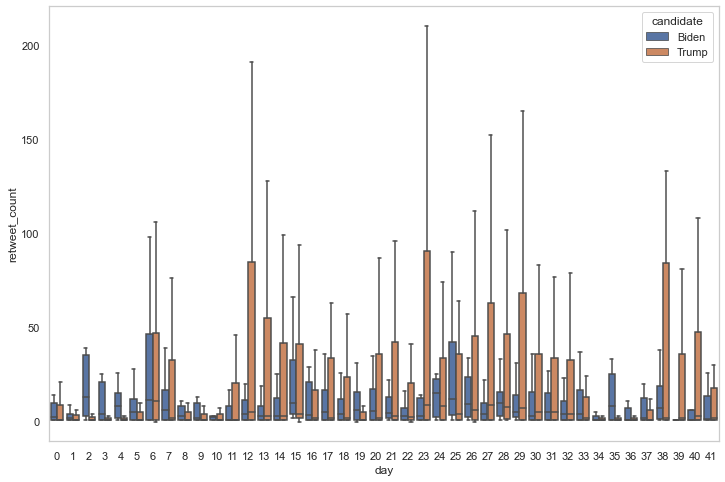

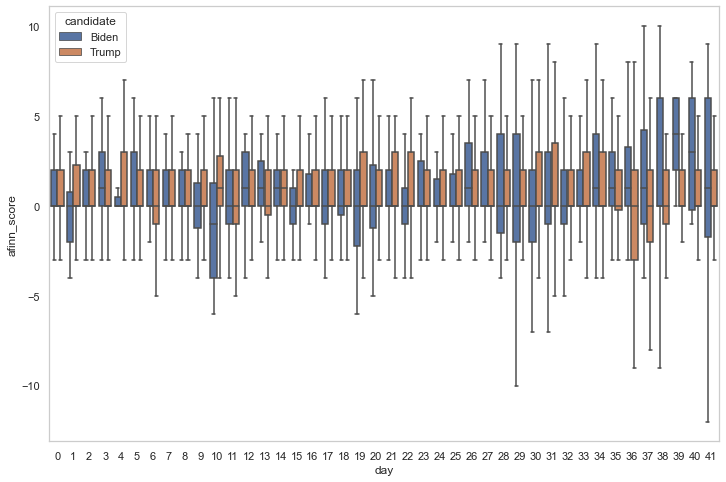

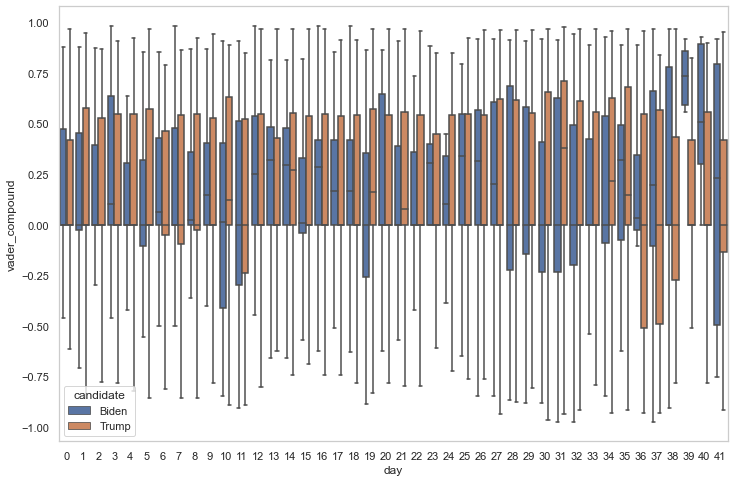

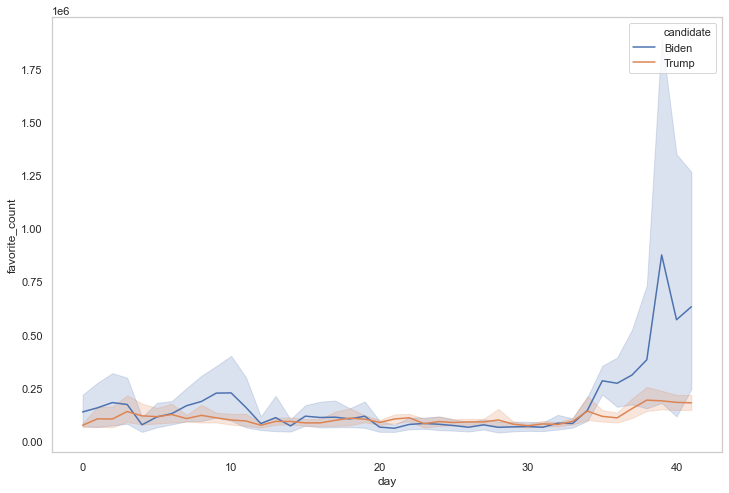

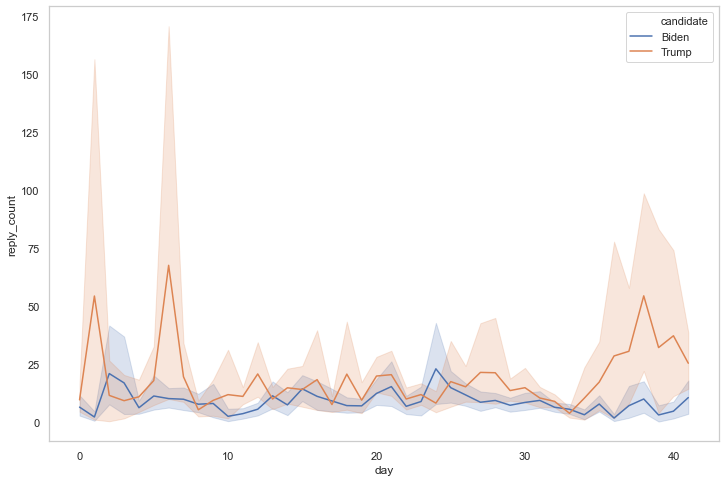

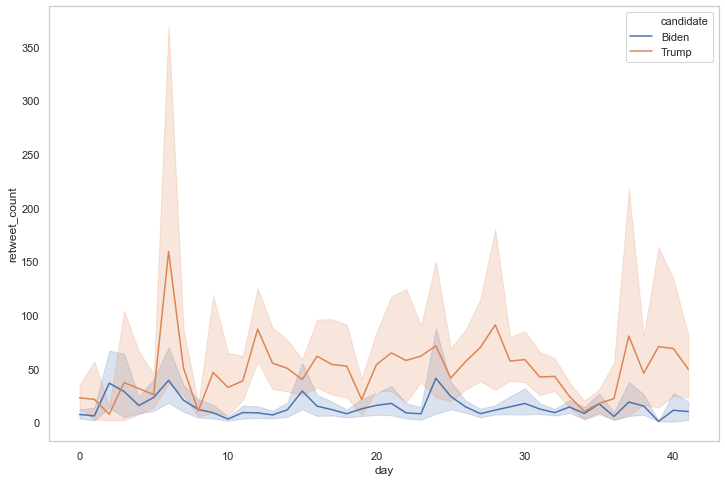

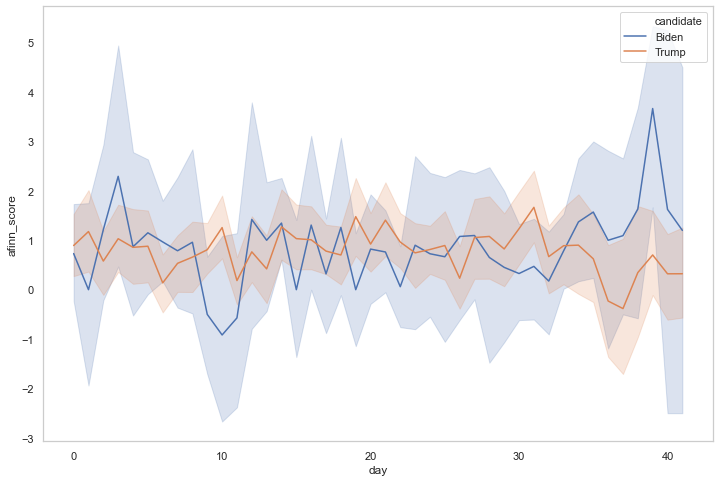

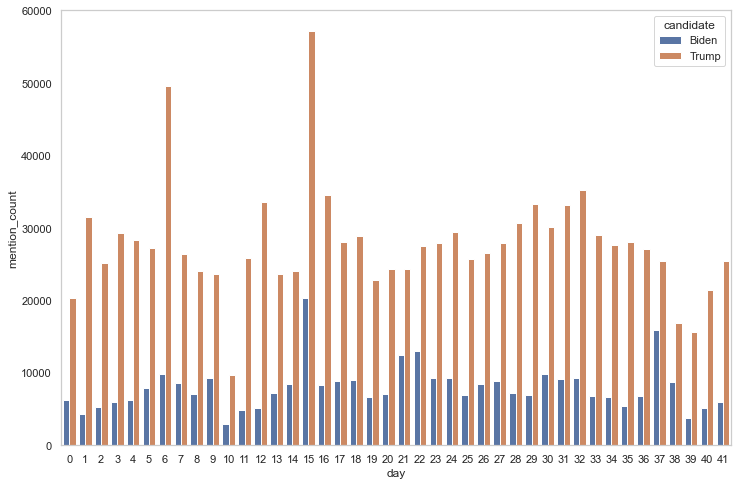

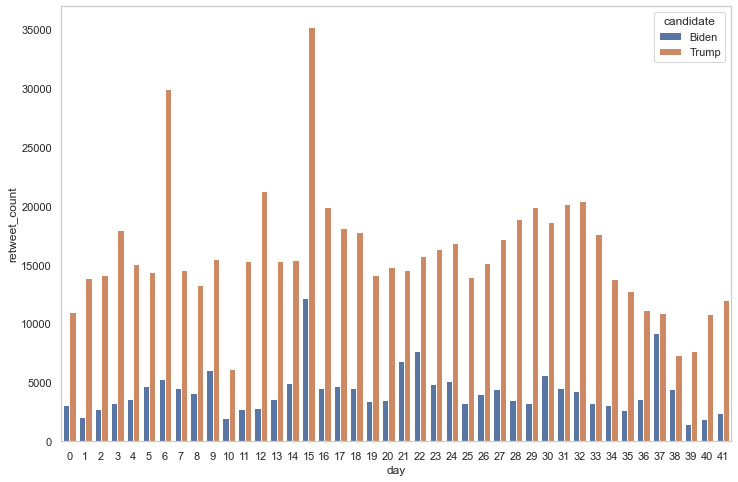

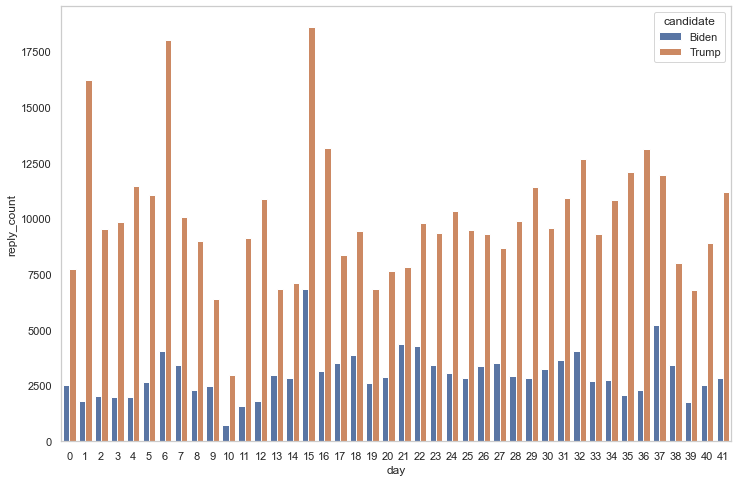

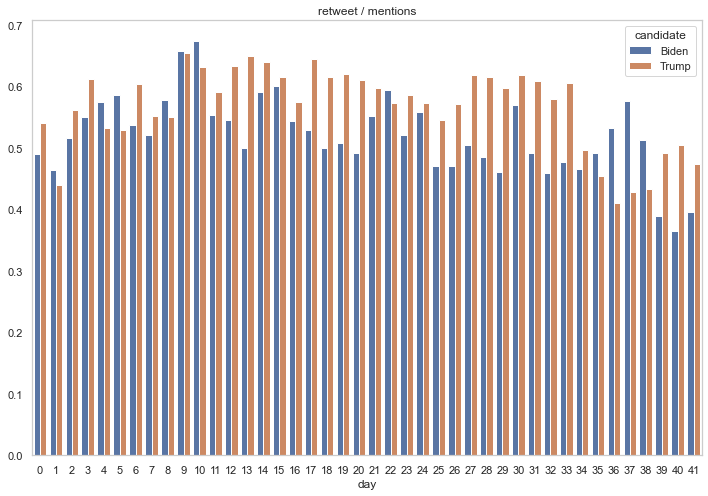

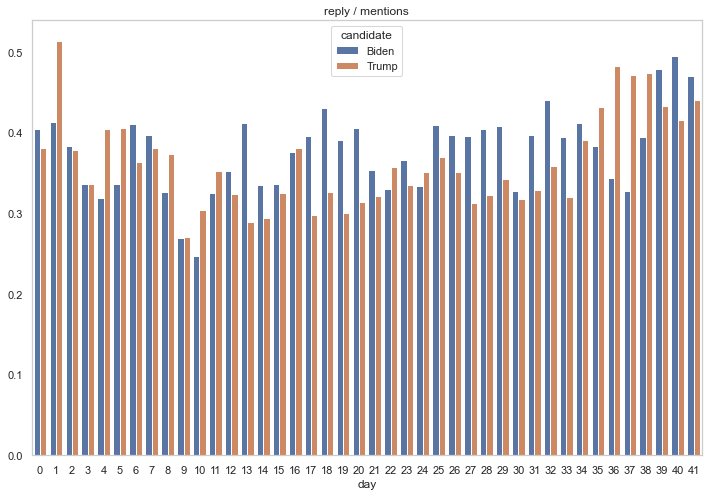

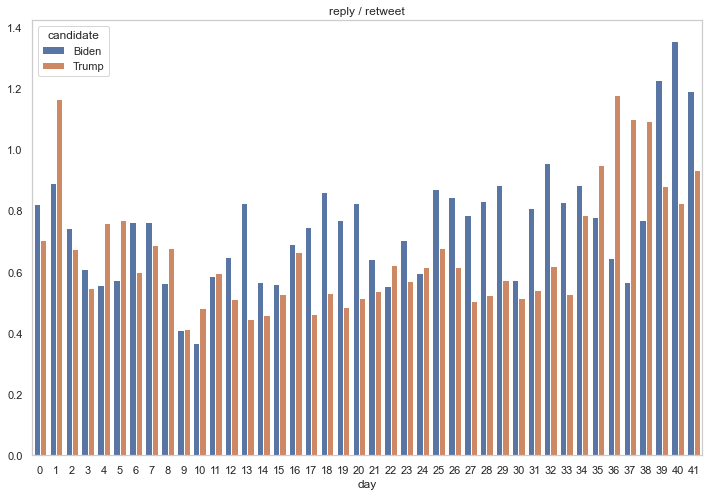

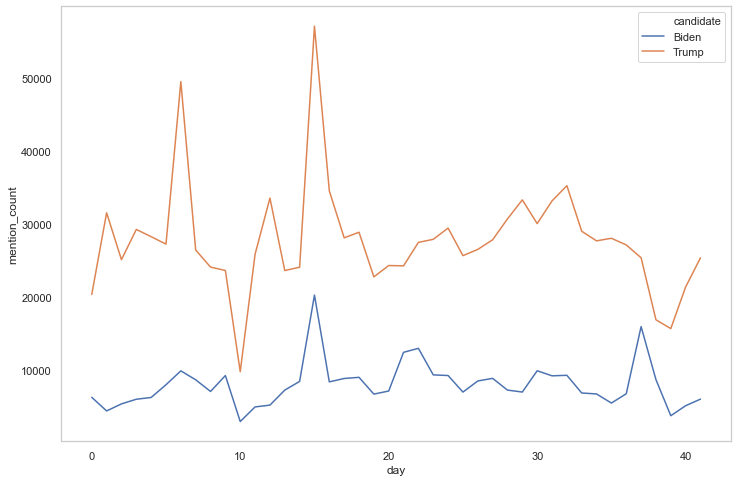

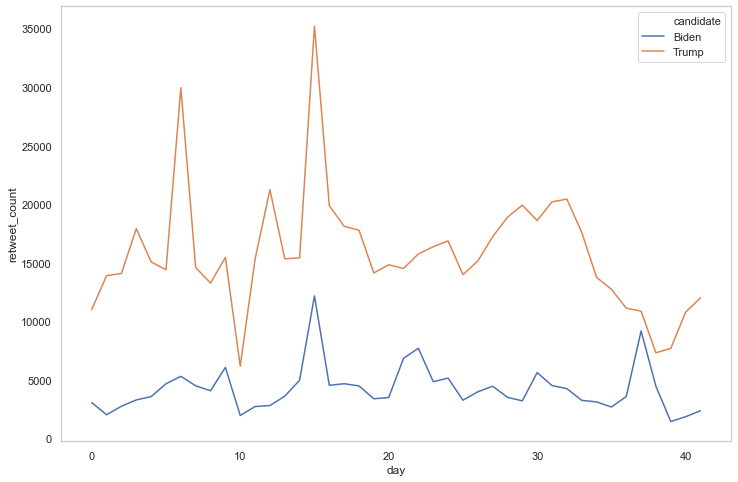

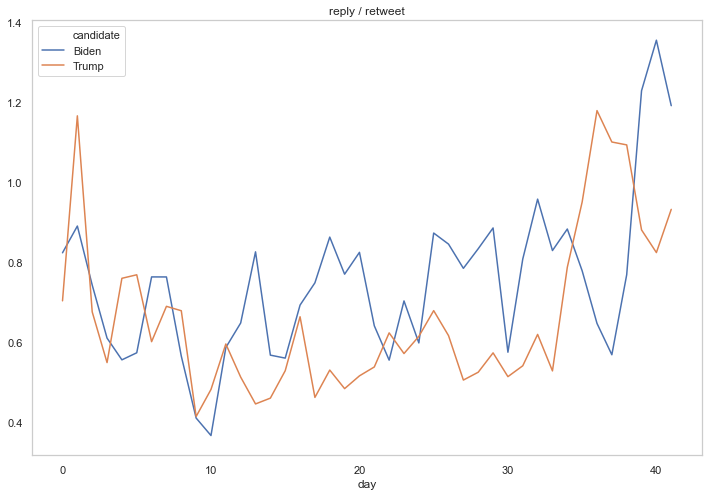

Biden
afinn_score summary:
Total tweets: 1082 | positive: 471 | neutral: 337 | negative: 274
mean score: 0.7495378927911276 | sum: 811.0
*****************************************
vader_compound summary:
Total tweets: 1082 | positive: 532 | neutral: 294 | negative: 256
mean score: 0.14758086876155269 | sum: 159.68250000000003
*****************************************

Trump
afinn_score summary:
Total tweets: 3689 | positive: 1560 | neutral: 1366 | negative: 763
mean score: 0.8235294117647058 | sum: 3038.0
*****************************************
vader_compound summary:
Total tweets: 3689 | positive: 1659 | neutral: 1311 | negative: 719
mean score: 0.1563842504743833 | sum: 576.9014999999999
*****************************************


/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


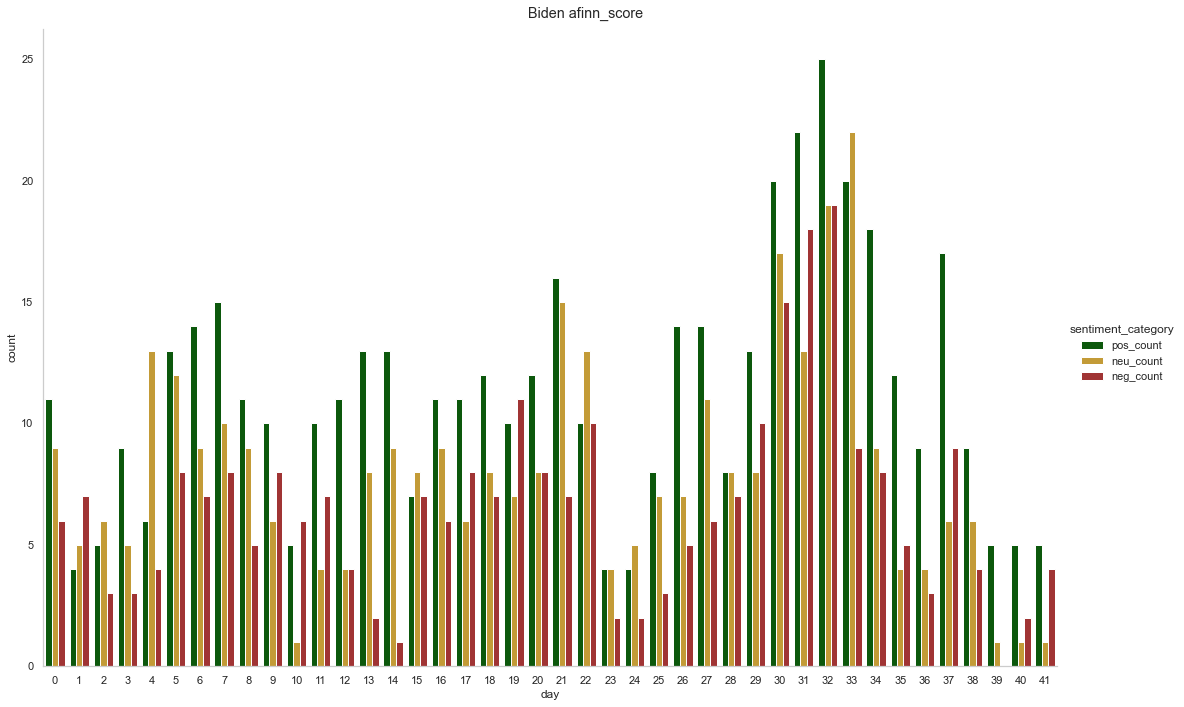

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


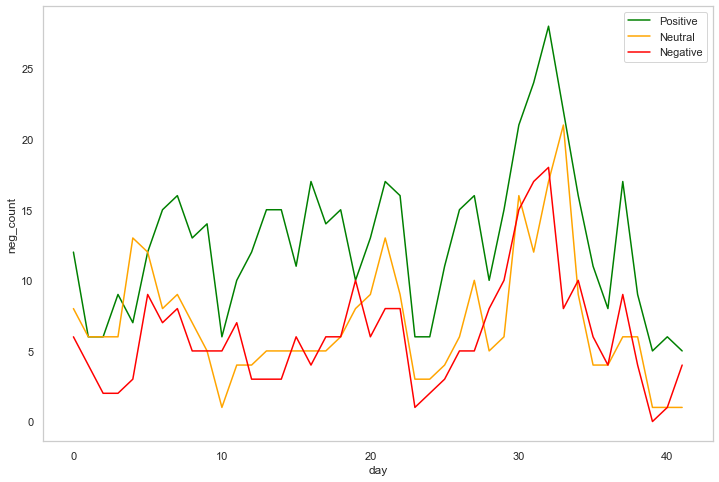

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


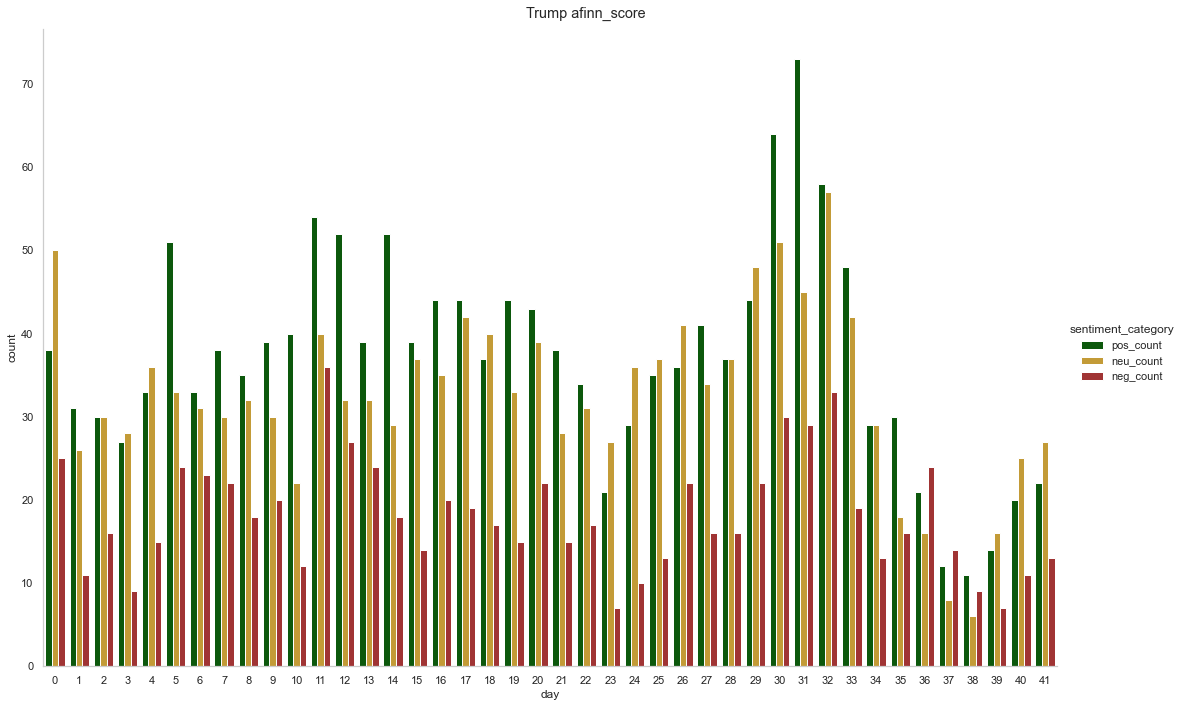

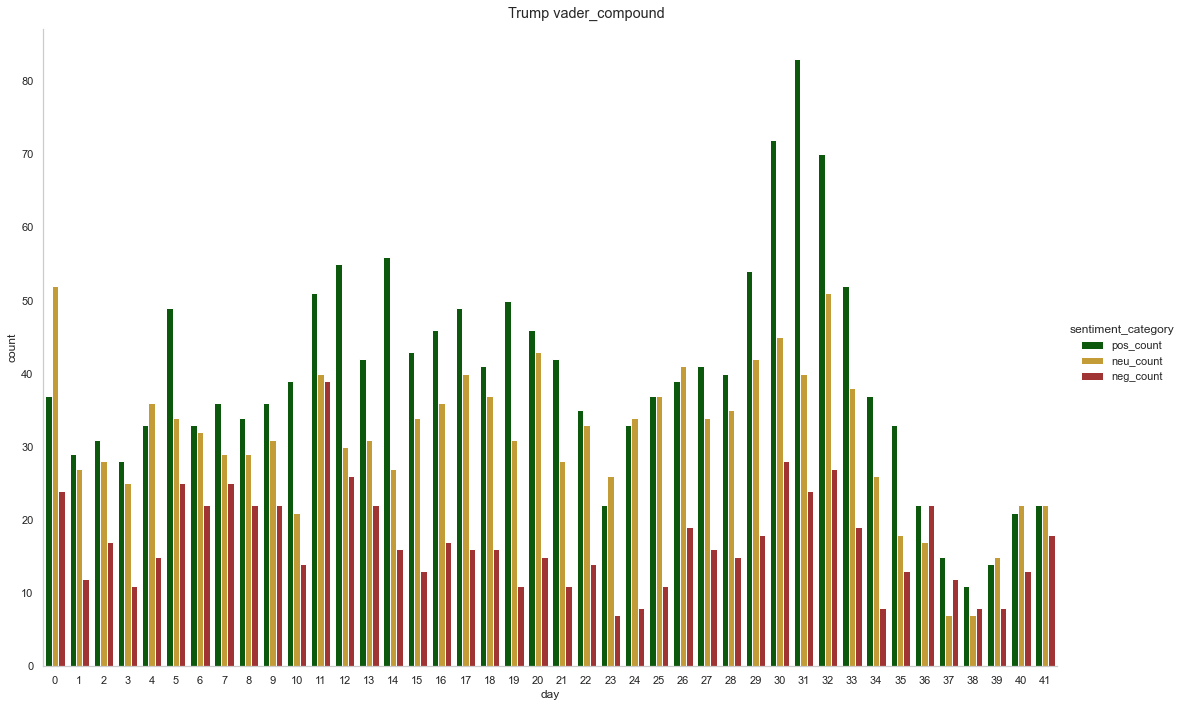

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


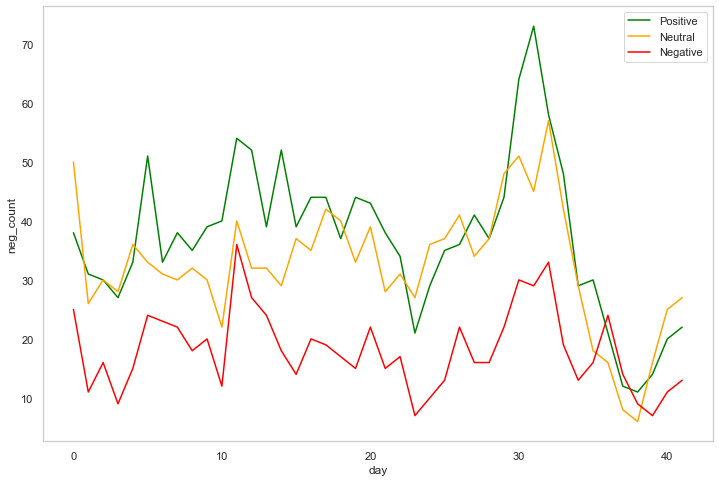

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


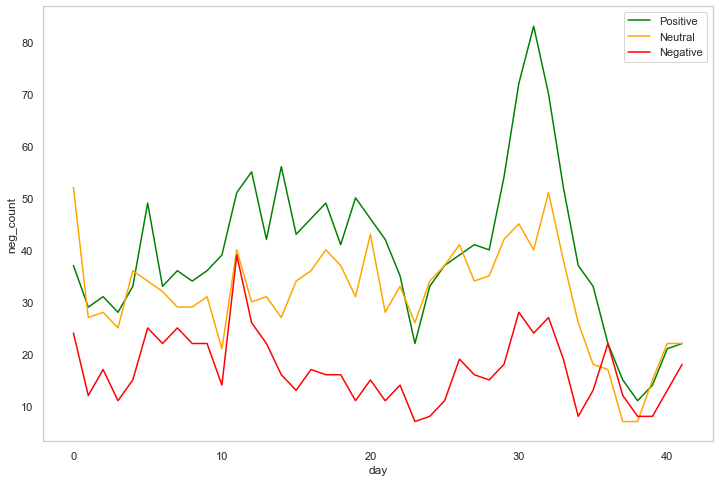

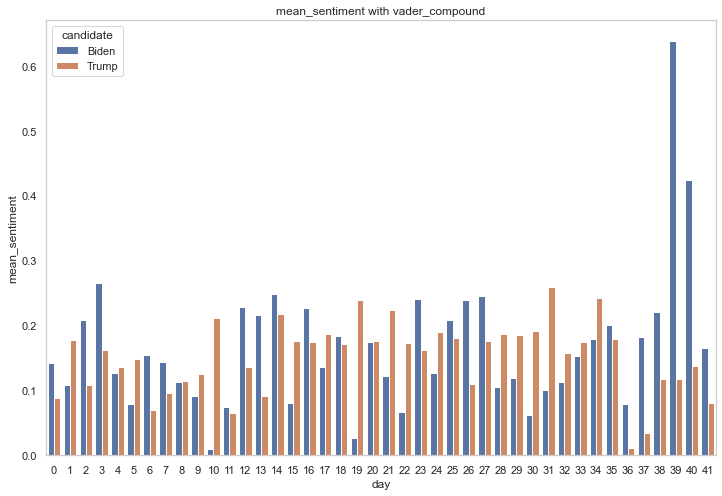

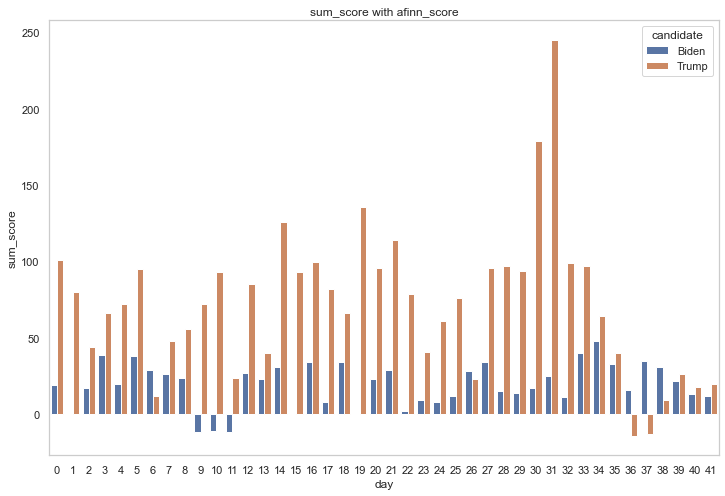

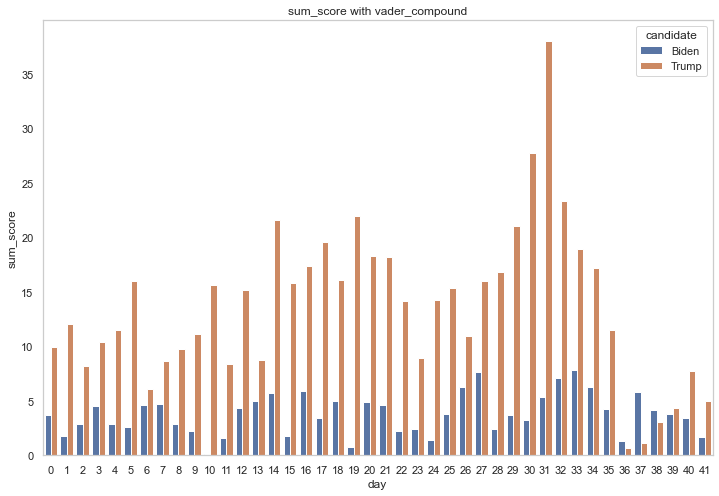

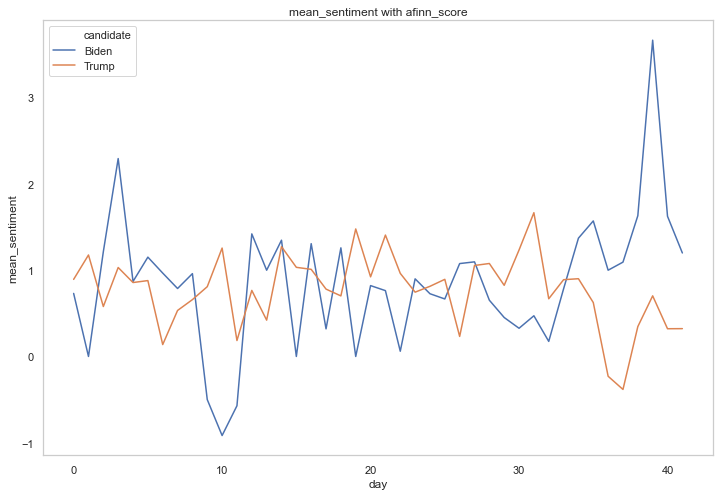

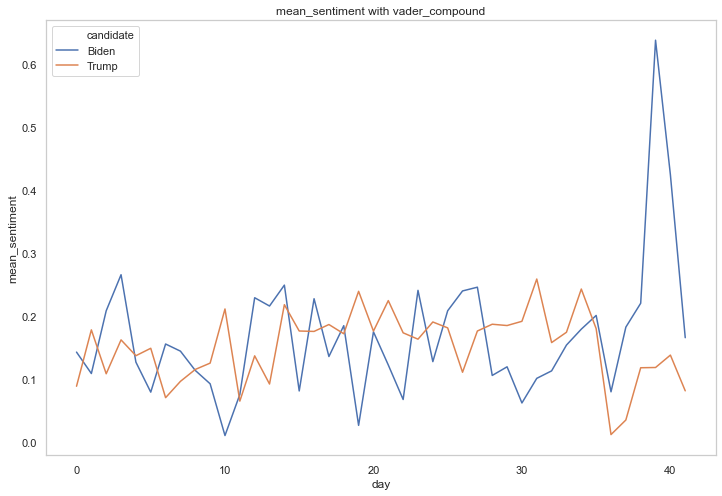

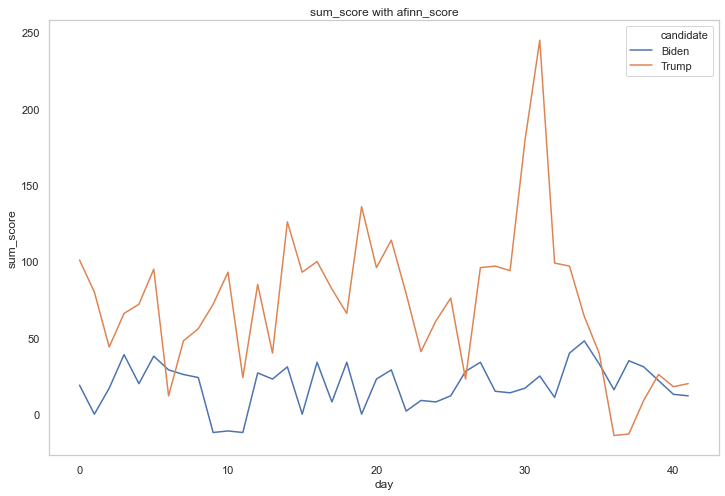

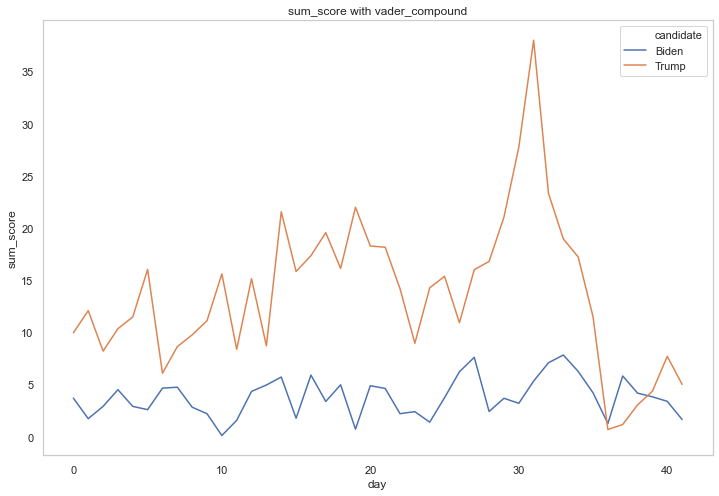

In [372]:
tbdf_plots(tbdf_1001_1111, mentions_1001_1111)

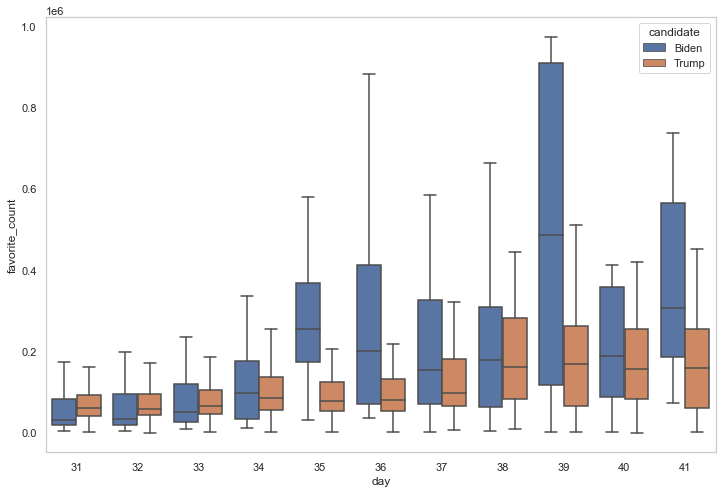

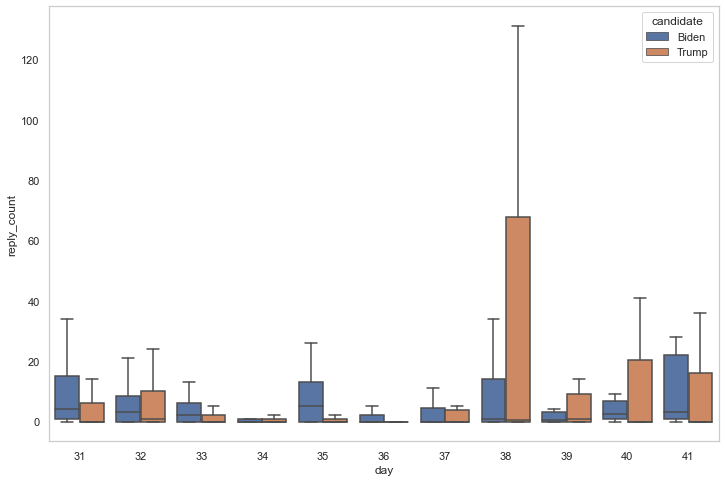

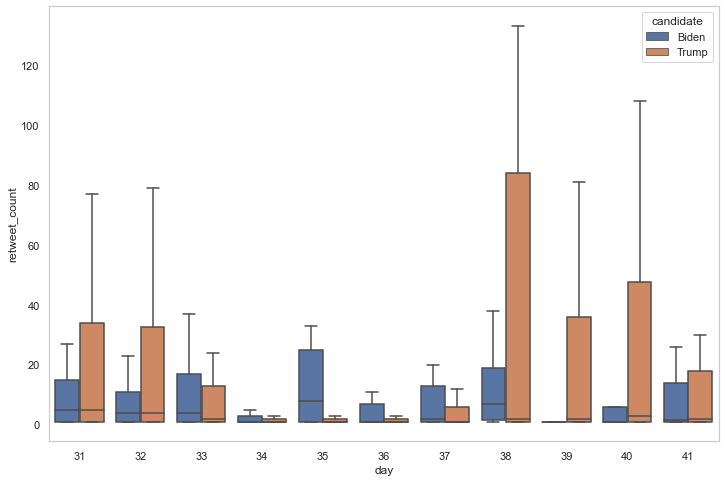

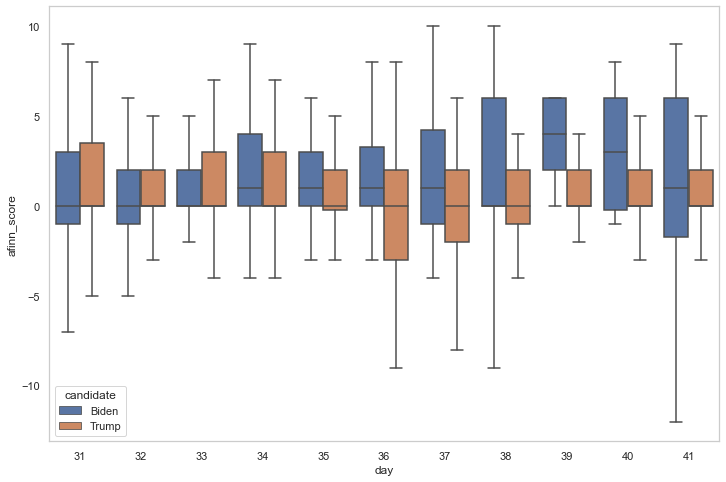

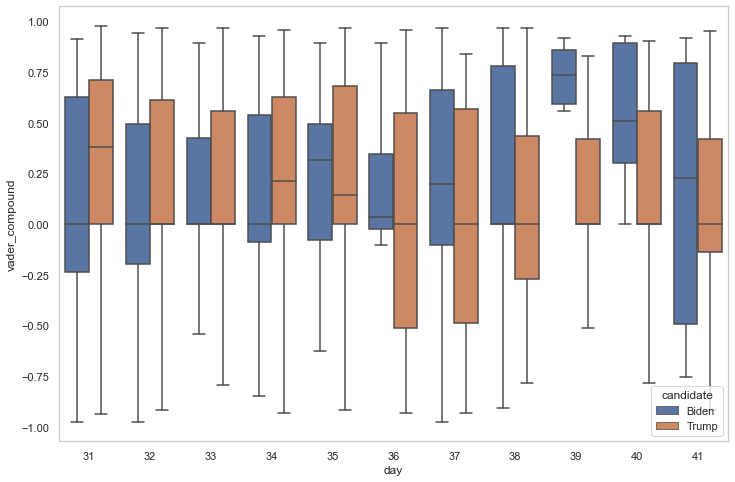

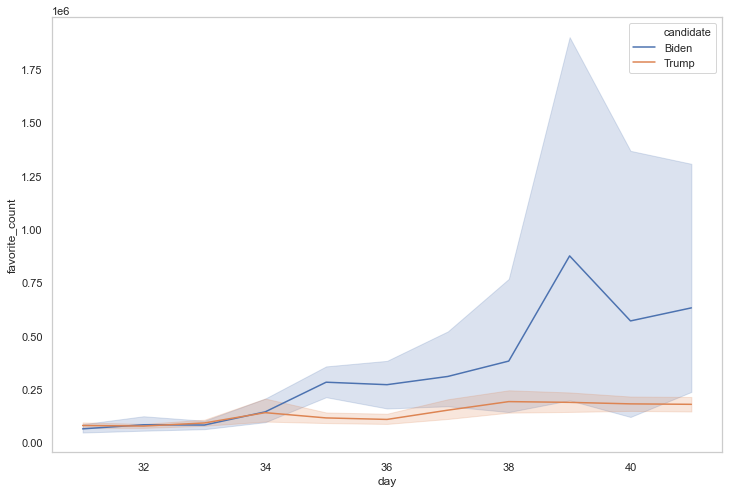

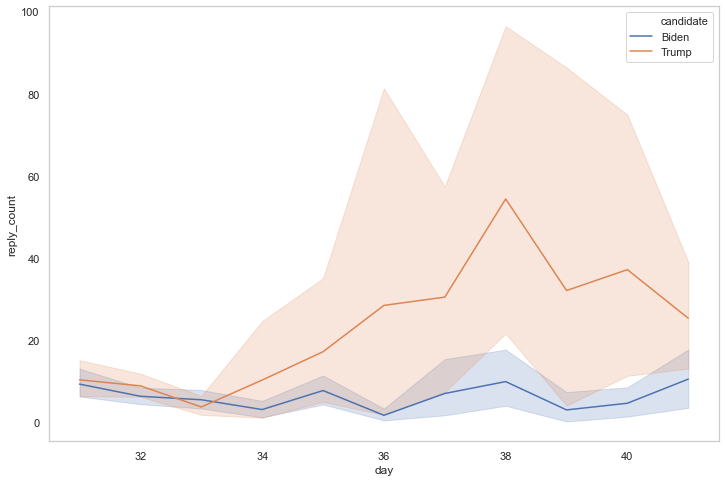

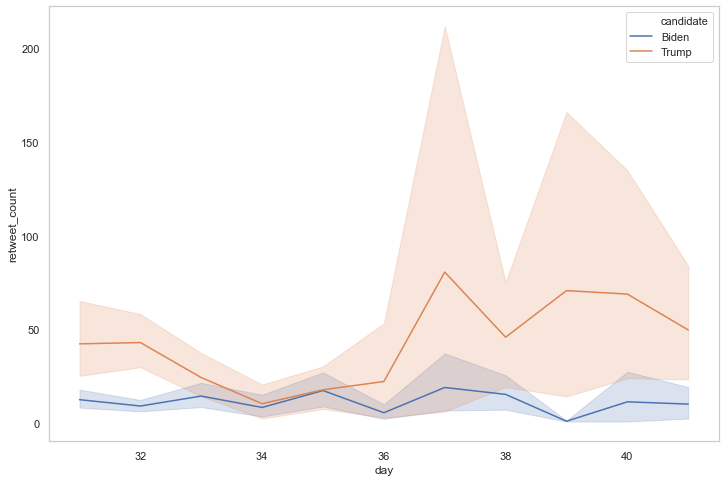

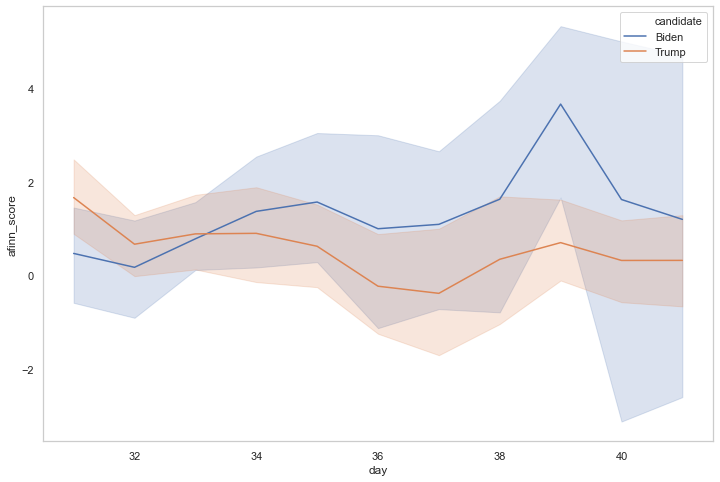

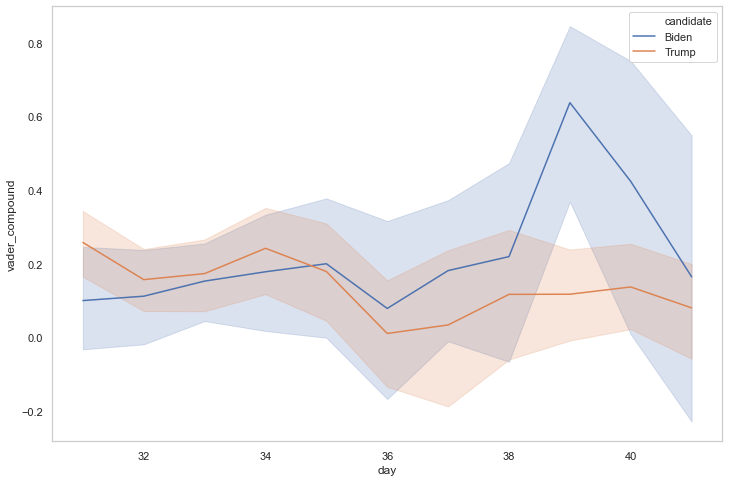

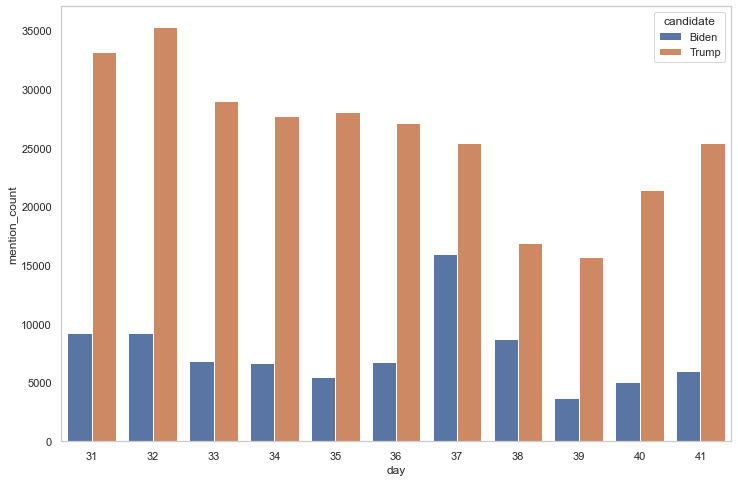

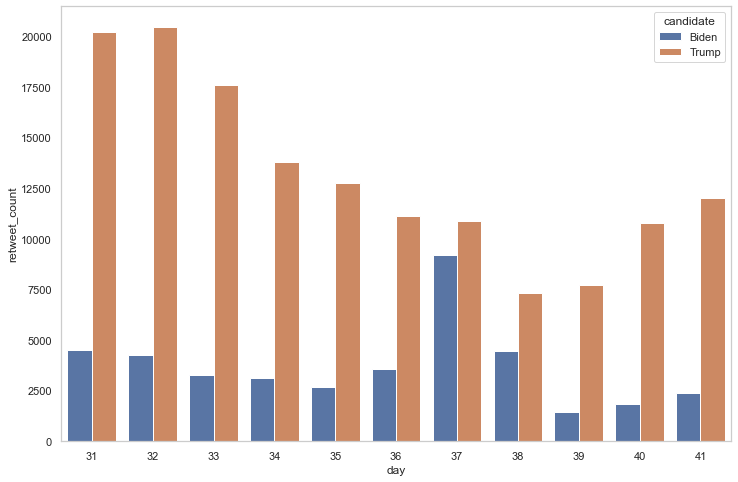

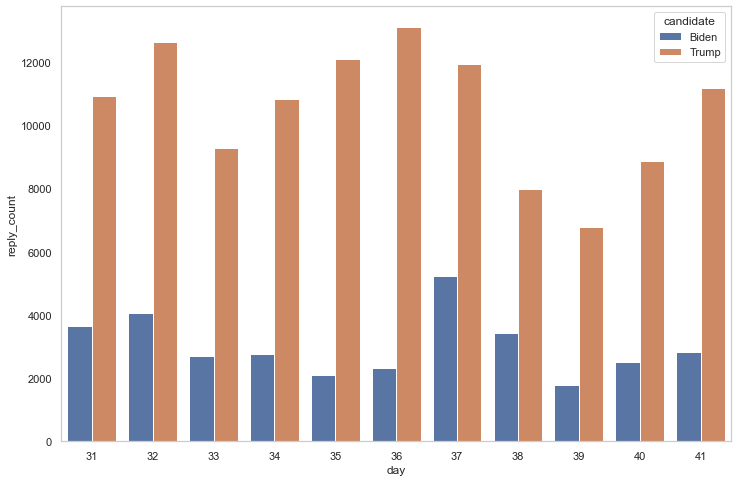

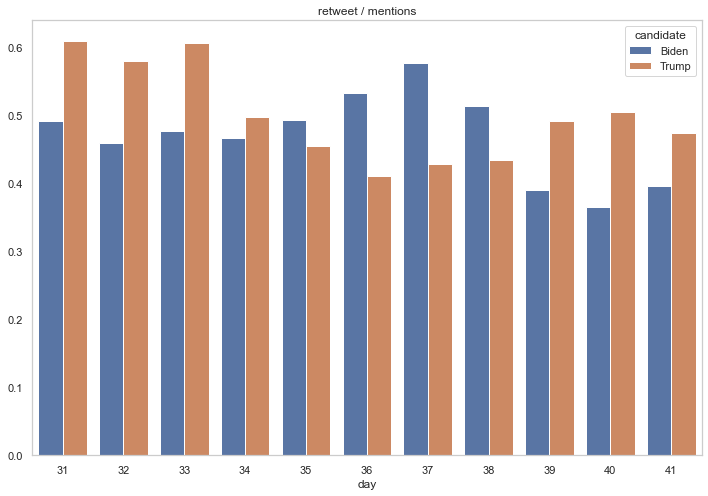

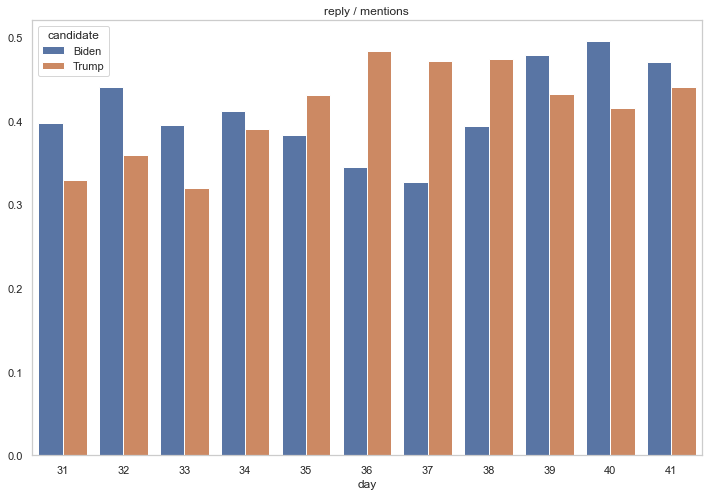

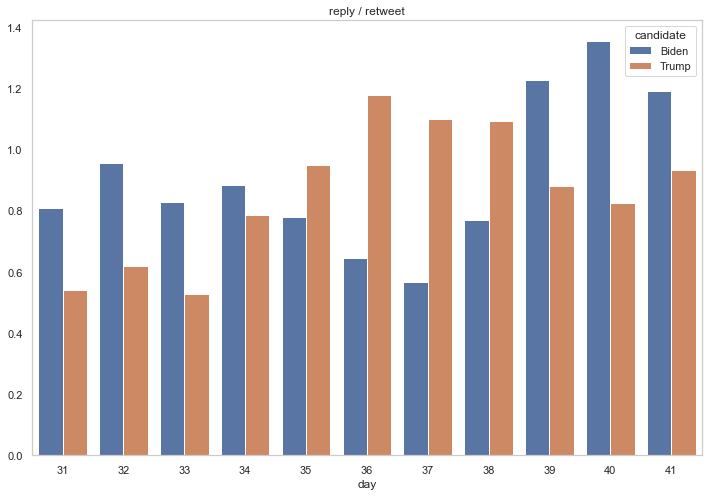

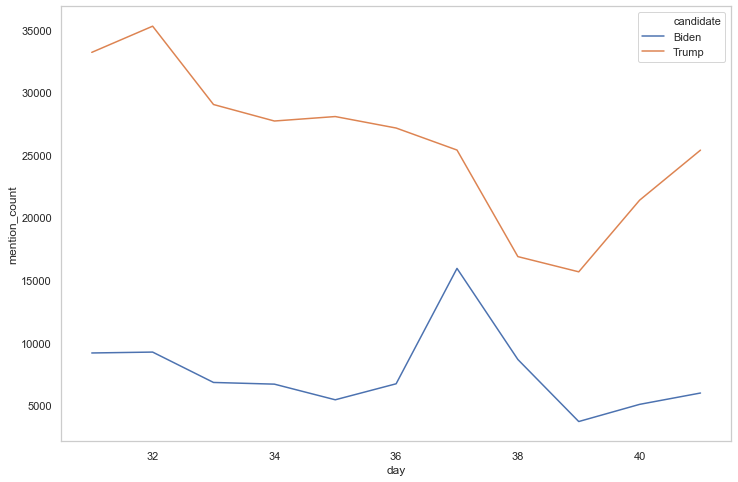

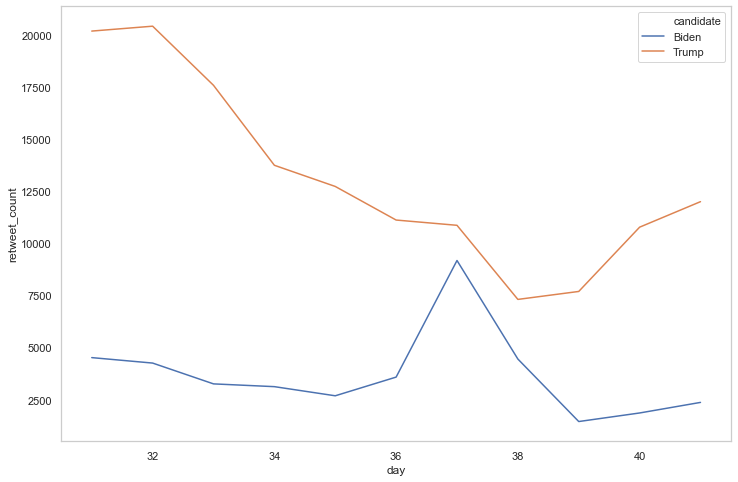

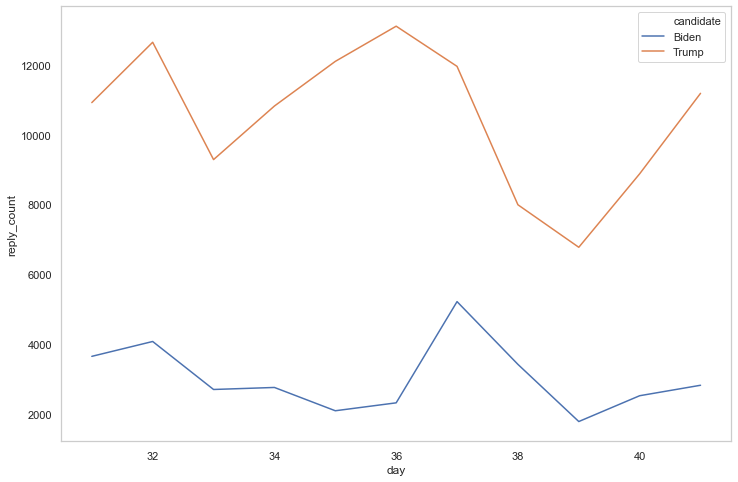

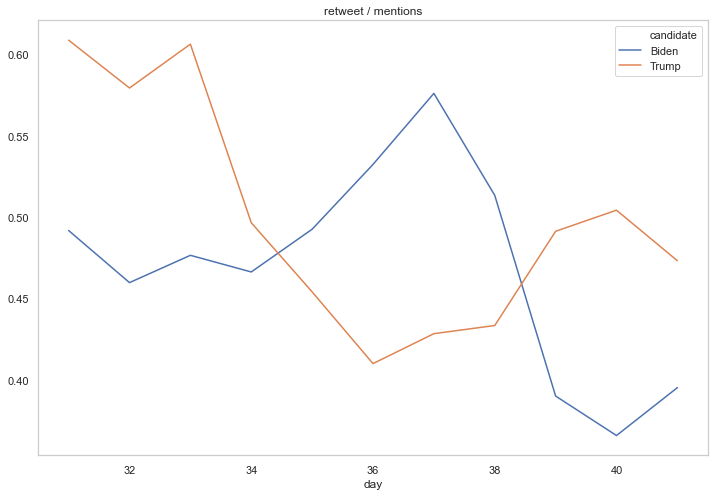

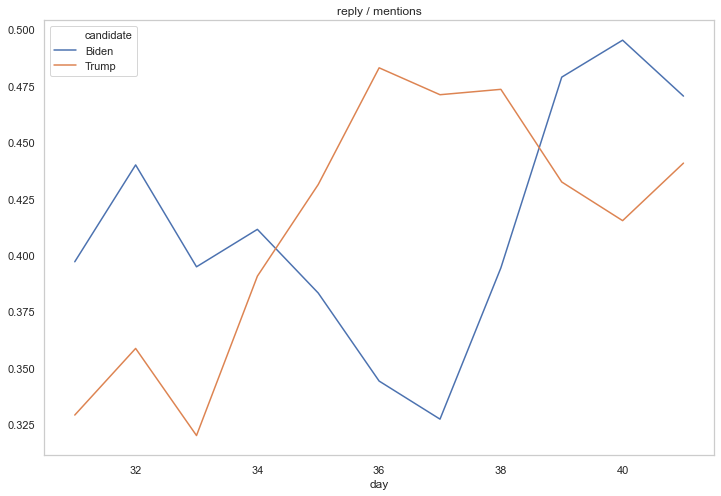

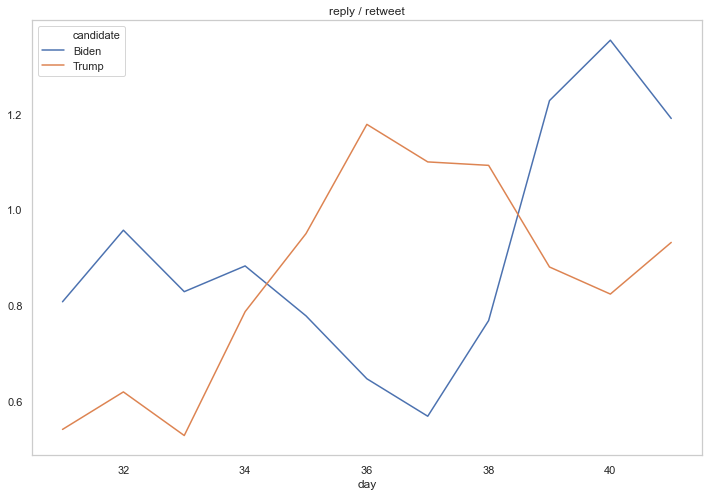

Biden
afinn_score summary:
Total tweets: 314 | positive: 147 | neutral: 86 | negative: 81
mean score: 0.910828025477707 | sum: 286.0
*****************************************
vader_compound summary:
Total tweets: 314 | positive: 151 | neutral: 82 | negative: 81
mean score: 0.16210382165605094 | sum: 50.9006
*****************************************

Trump
afinn_score summary:
Total tweets: 815 | positive: 338 | neutral: 289 | negative: 188
mean score: 0.7251533742331289 | sum: 591.0
*****************************************
vader_compound summary:
Total tweets: 815 | positive: 380 | neutral: 263 | negative: 172
mean score: 0.1607842944785276 | sum: 131.03920000000016
*****************************************


/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


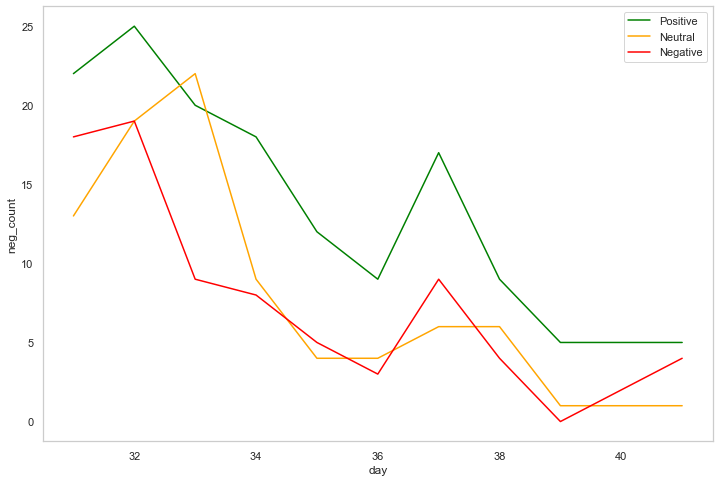

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


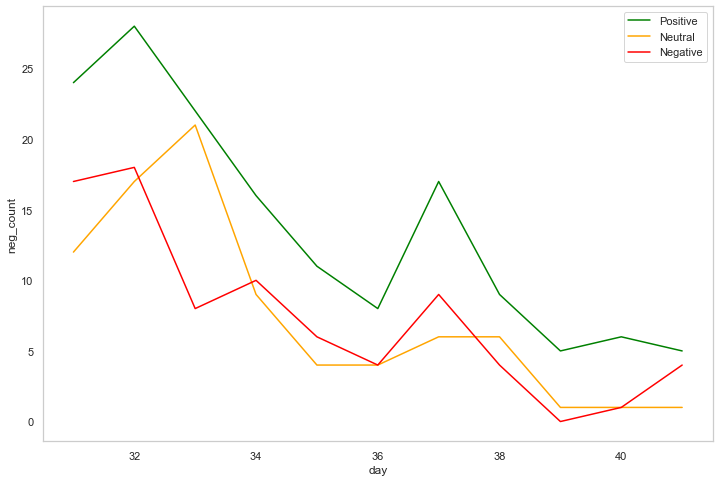

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


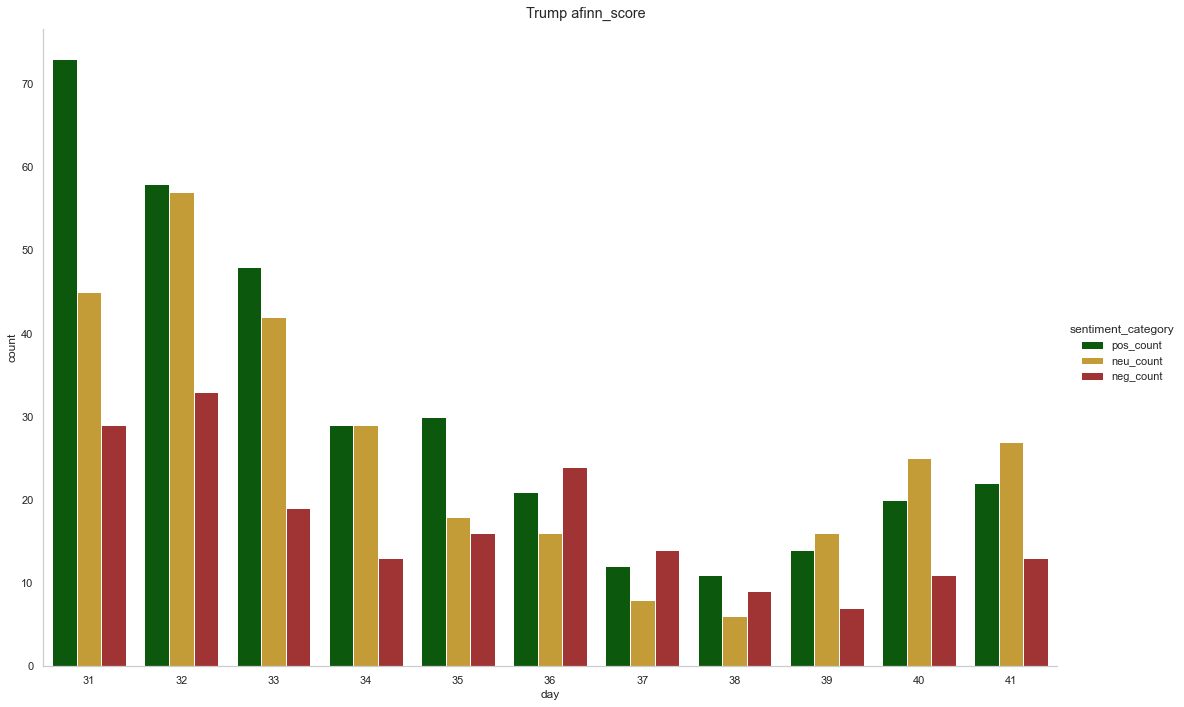

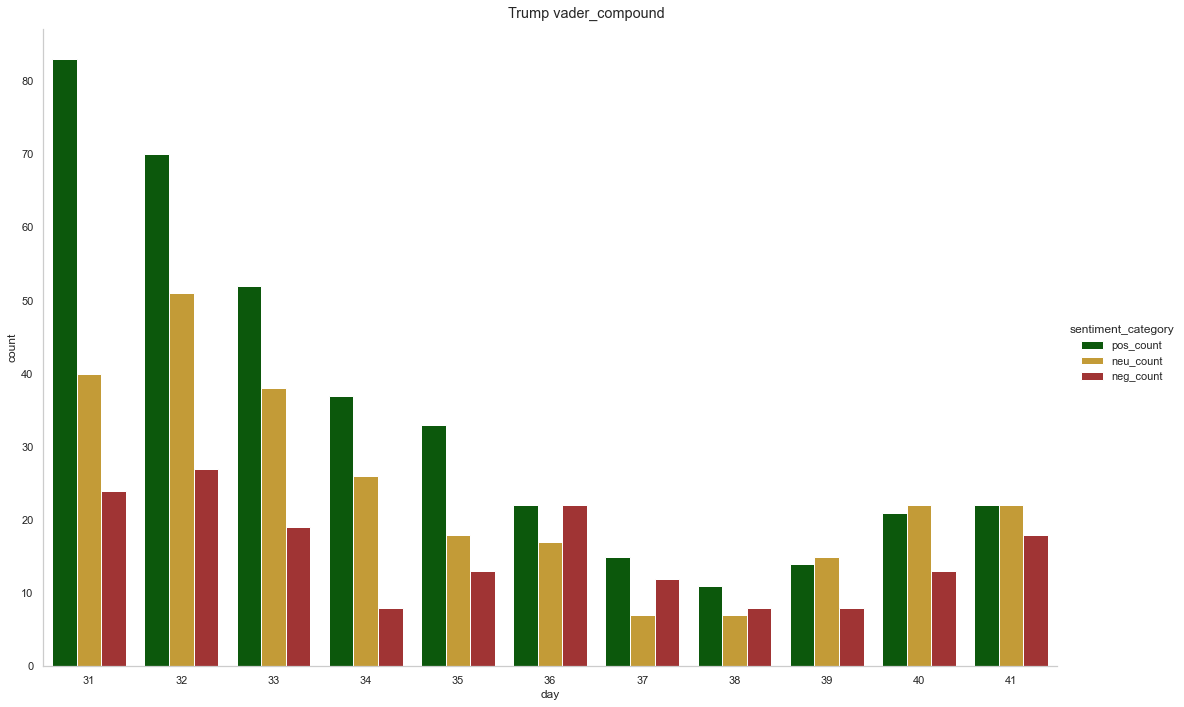

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


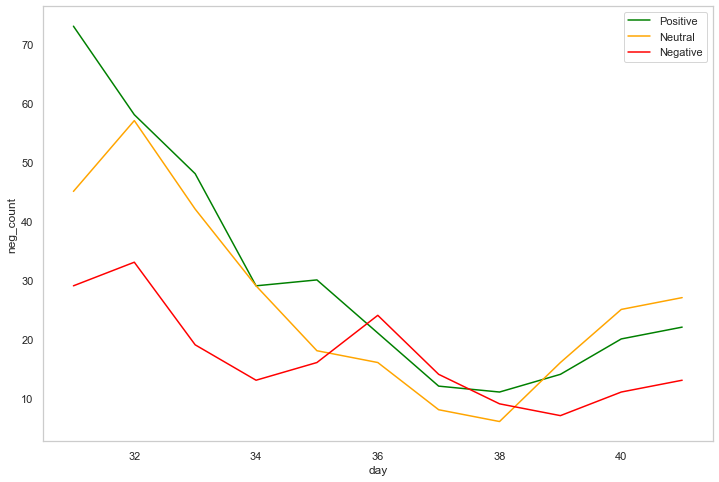

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


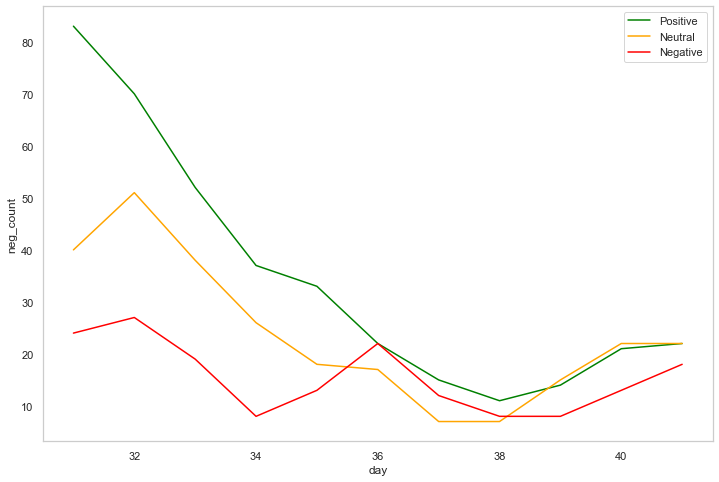

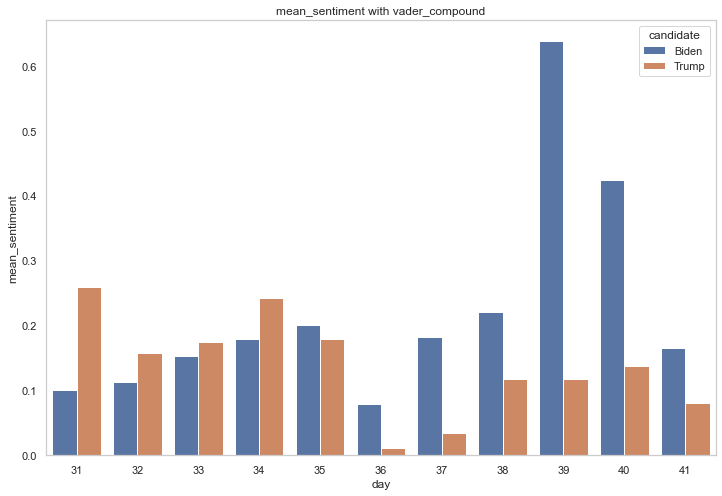

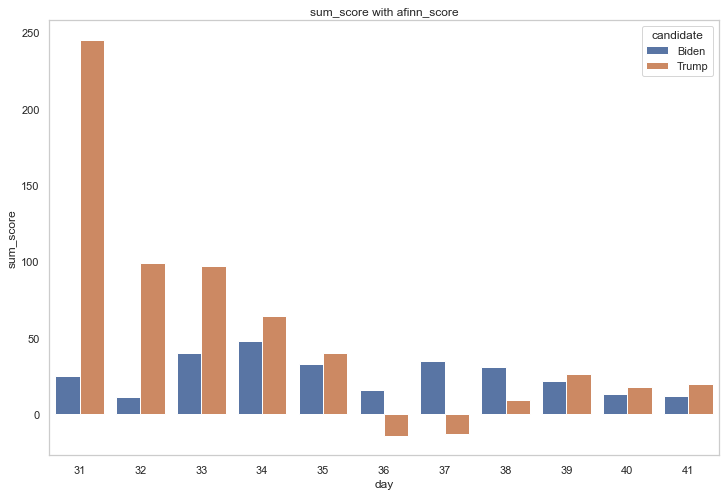

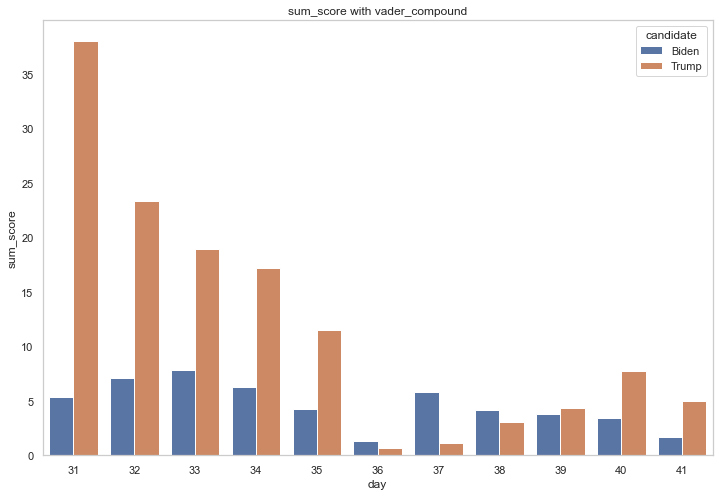

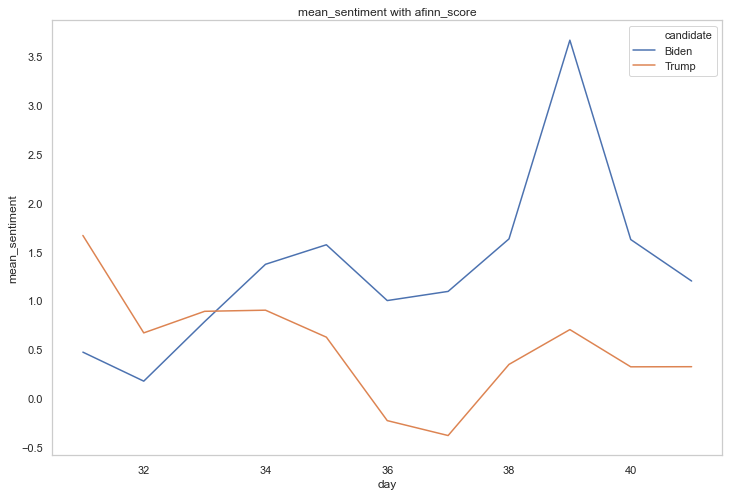

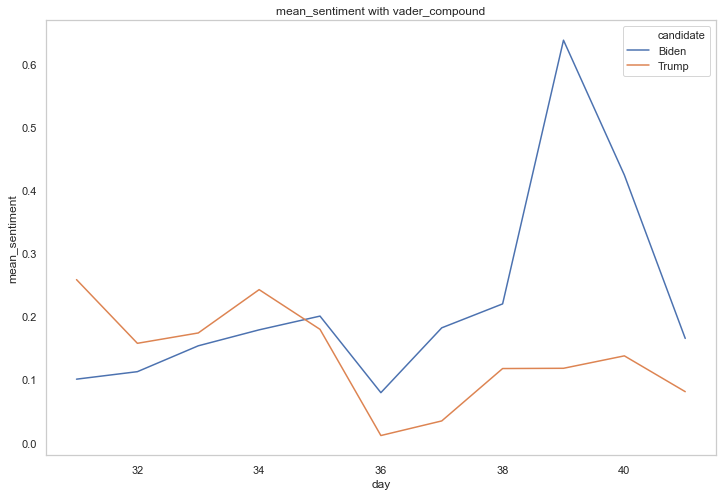

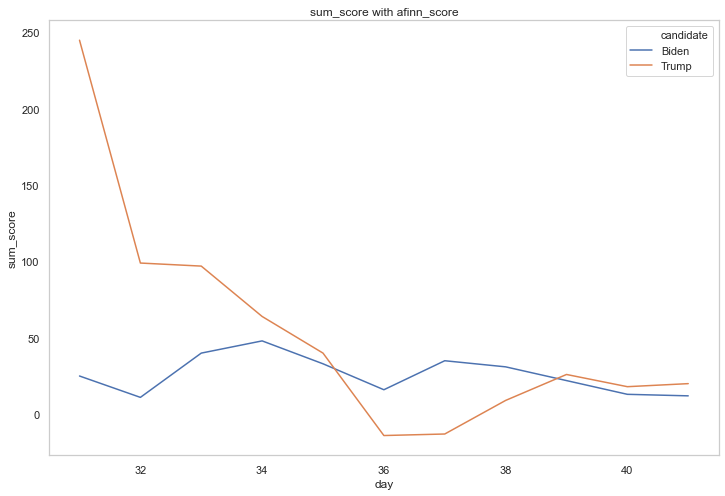

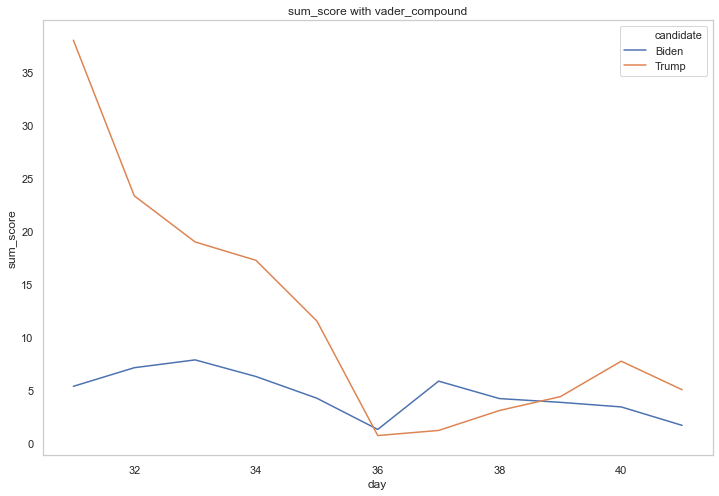

In [376]:
tbdf_plots(tbdf_1001_1111[tbdf_1001_1111.day >= 31].reset_index(), mentions_1001_1111[mentions_1001_1111.day >= 31].reset_index())

- Oct 7: VP debate
- Oct 8: Michigan governor kidnap plan

In [382]:
file_objs_lst[:4]

[{'id': '1LSCTQa1dnS052tnBoeu0GgR4W1YdgChL',
  'kind': 'drive#file',
  'mimeType': 'application/octet-stream',
  'name': 'combined_tweets-2020-11-15.pkl'},
 {'id': '1PcvQLfpKz7FMfCNOW2dpsVtElcqUfXZs',
  'kind': 'drive#file',
  'mimeType': 'application/octet-stream',
  'name': 'combined_tweets-2020-11-14.pkl'},
 {'id': '1LQcwo_nHk377FH4i1KlAC3Owyl1fiWAq',
  'kind': 'drive#file',
  'mimeType': 'application/octet-stream',
  'name': 'combined_tweets-2020-11-13.pkl'},
 {'id': '1K21eptLsBE1h8PrjKxqFN0PEUJZV-eQ7',
  'kind': 'drive#file',
  'mimeType': 'application/octet-stream',
  'name': 'combined_tweets-2020-11-12.pkl'}]

In [383]:
tbdf_1112_1115, mentions_1112_1115 = create_candidate_tweet_df(file_objs_lst[:4])

Download 39%.
Download 78%.
Download 100%.
Day 0 finished
Download 39%.
Download 78%.
Download 100%.
Day 1 finished
Download 38%.
Download 76%.
Download 100%.
Day 2 finished
Download 36%.
Download 72%.
Download 100%.
Day 3 finished


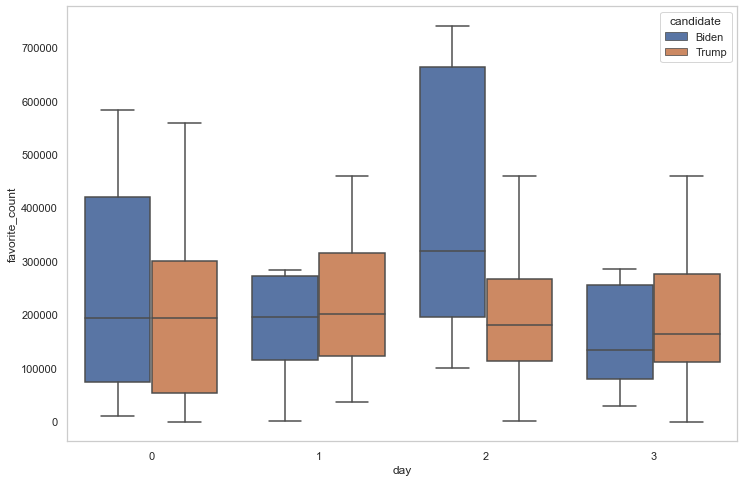

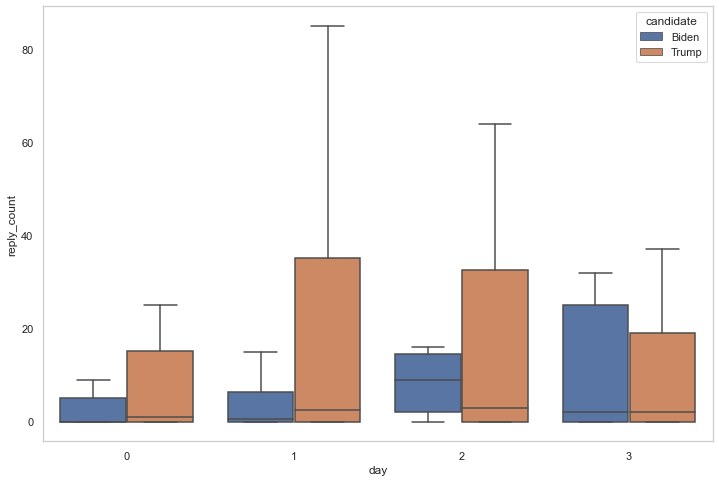

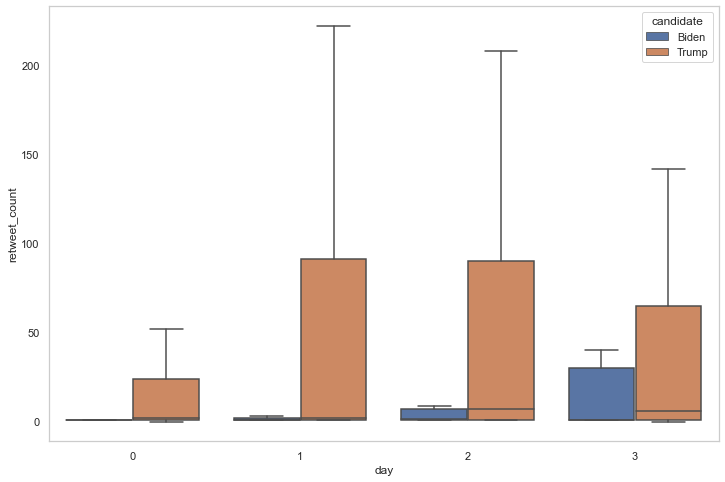

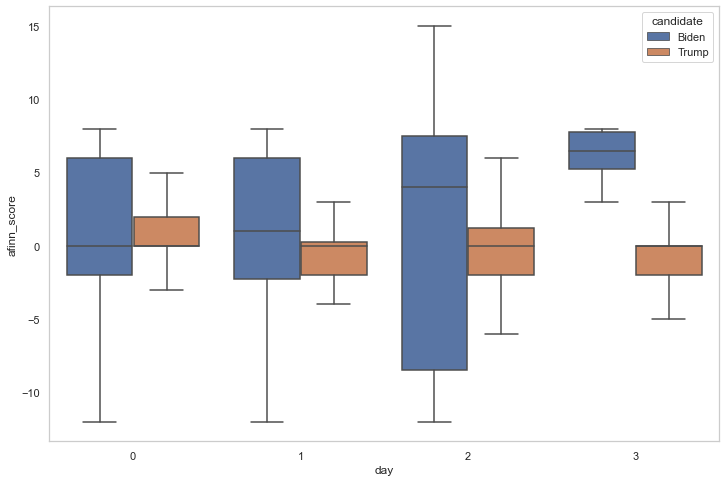

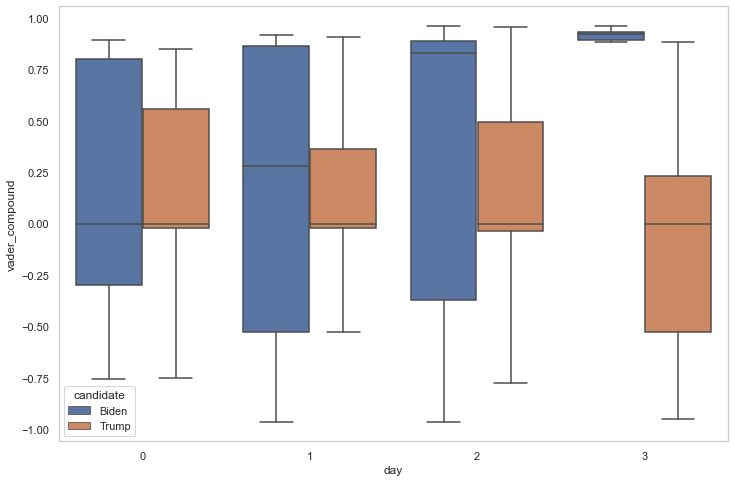

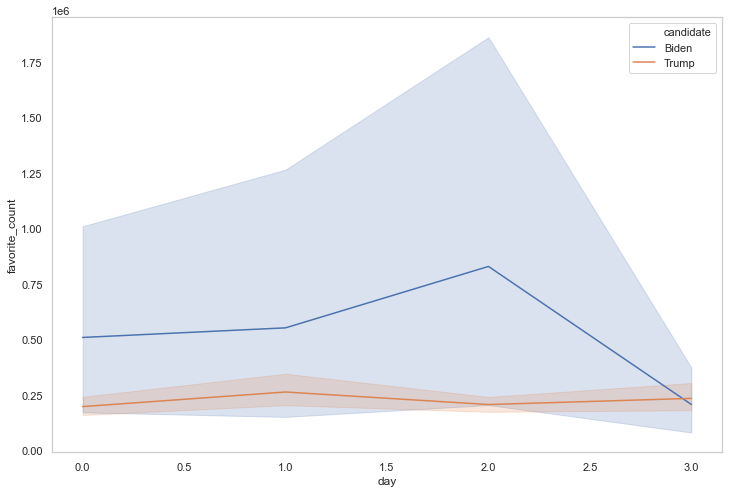

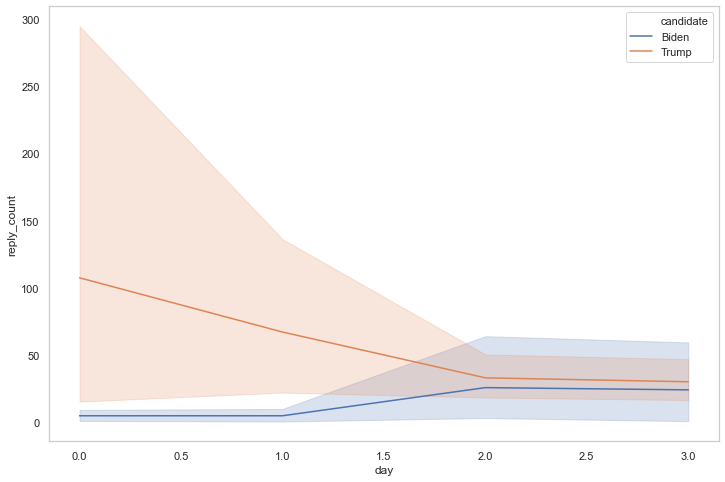

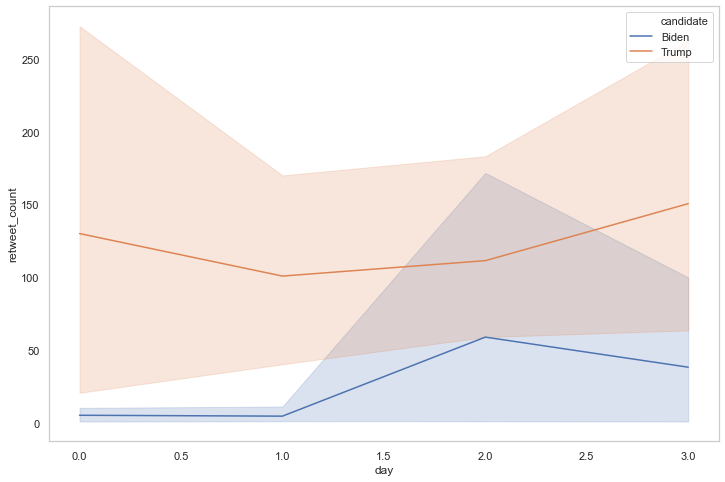

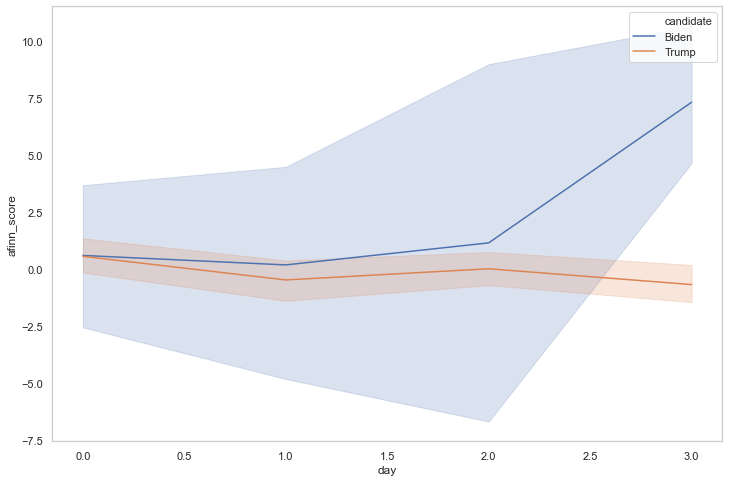

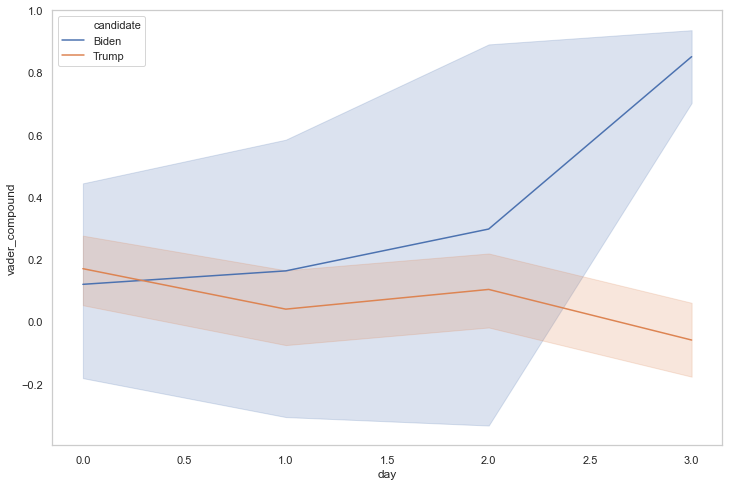

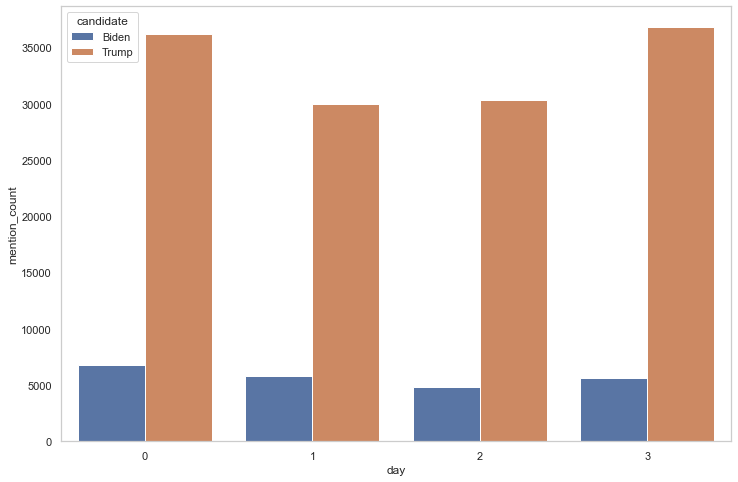

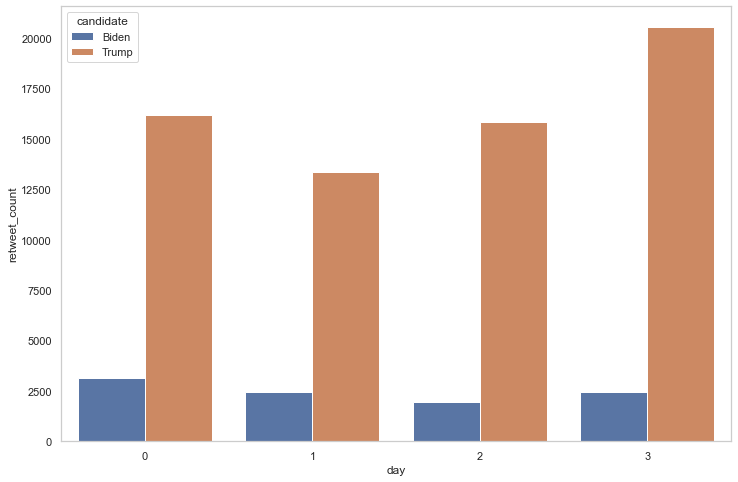

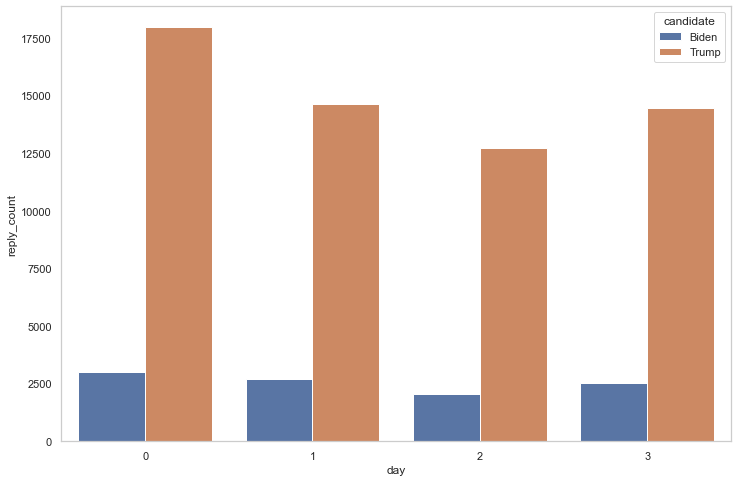

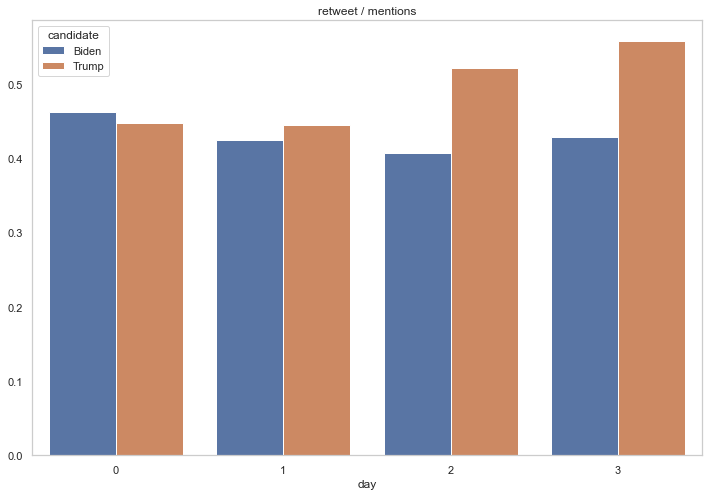

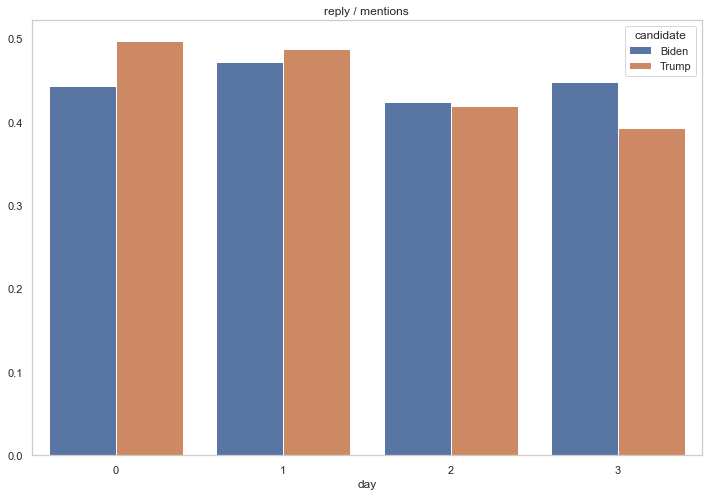

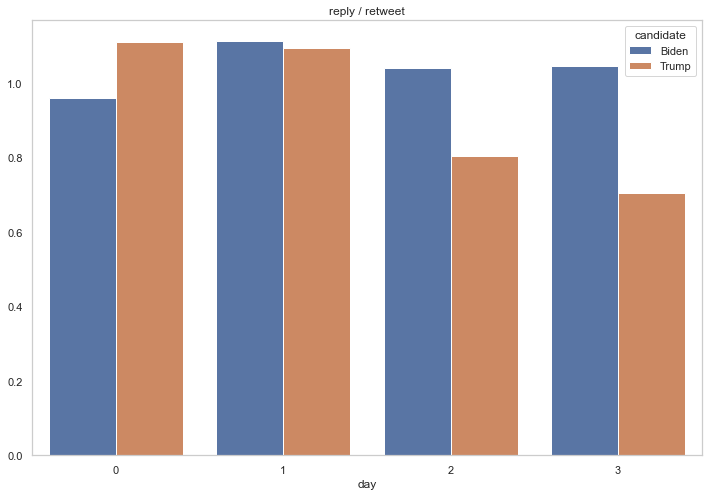

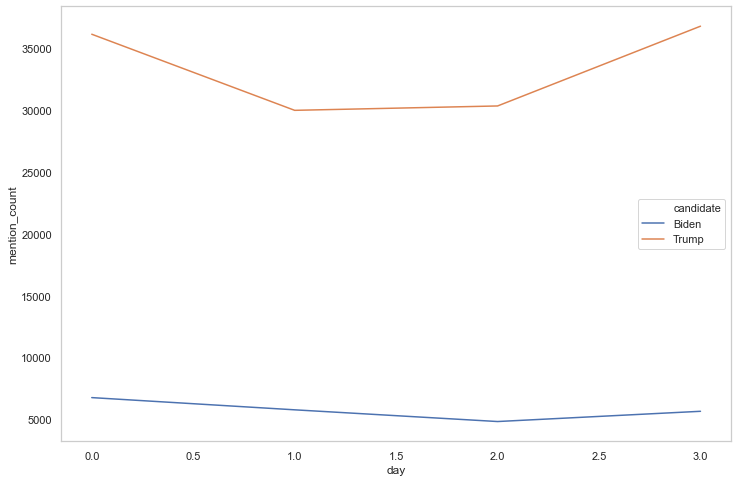

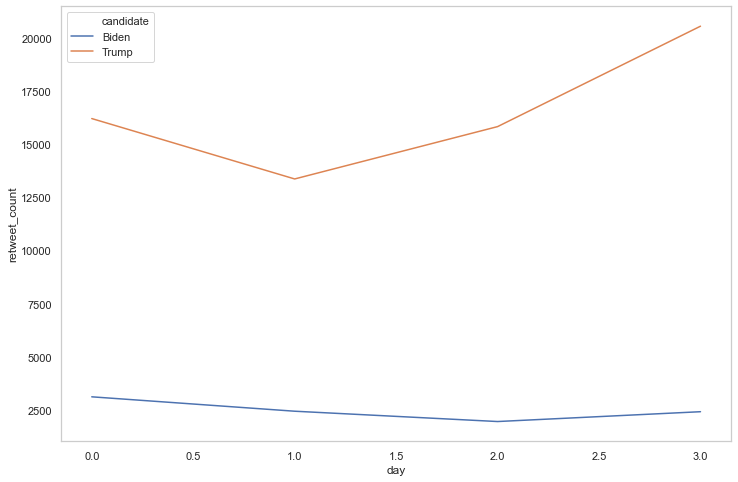

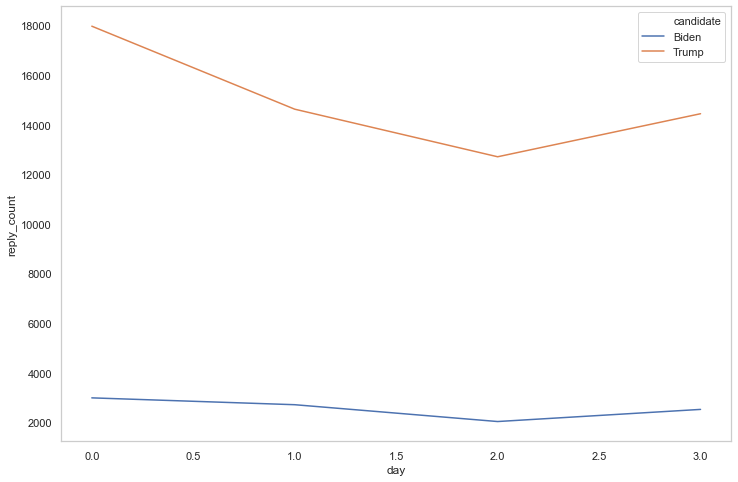

Biden
afinn_score summary:
Total tweets: 35 | positive: 19 | neutral: 6 | negative: 10
mean score: 1.7428571428571429 | sum: 61.0
*****************************************
vader_compound summary:
Total tweets: 35 | positive: 20 | neutral: 6 | negative: 9
mean score: 0.2880314285714286 | sum: 10.081100000000001
*****************************************

Trump
afinn_score summary:
Total tweets: 229 | positive: 69 | neutral: 85 | negative: 75
mean score: -0.14410480349344978 | sum: -33.0
*****************************************
vader_compound summary:
Total tweets: 229 | positive: 89 | neutral: 77 | negative: 63
mean score: 0.05906288209606987 | sum: 13.525400000000001
*****************************************


/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


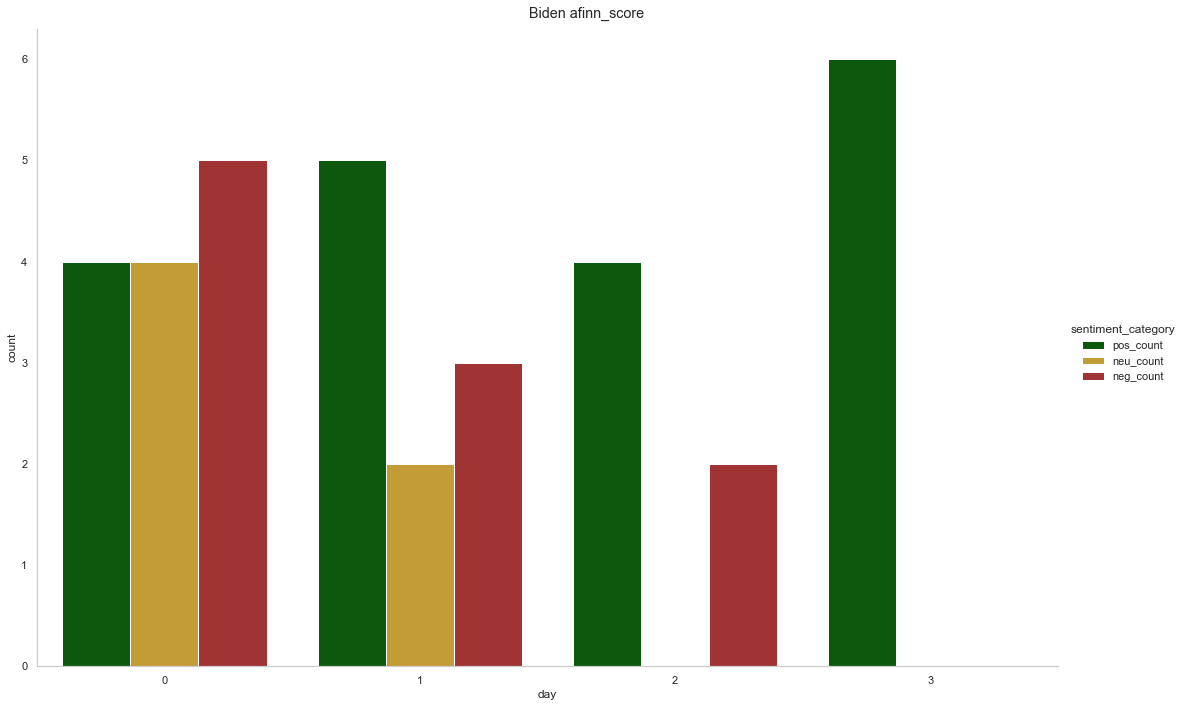

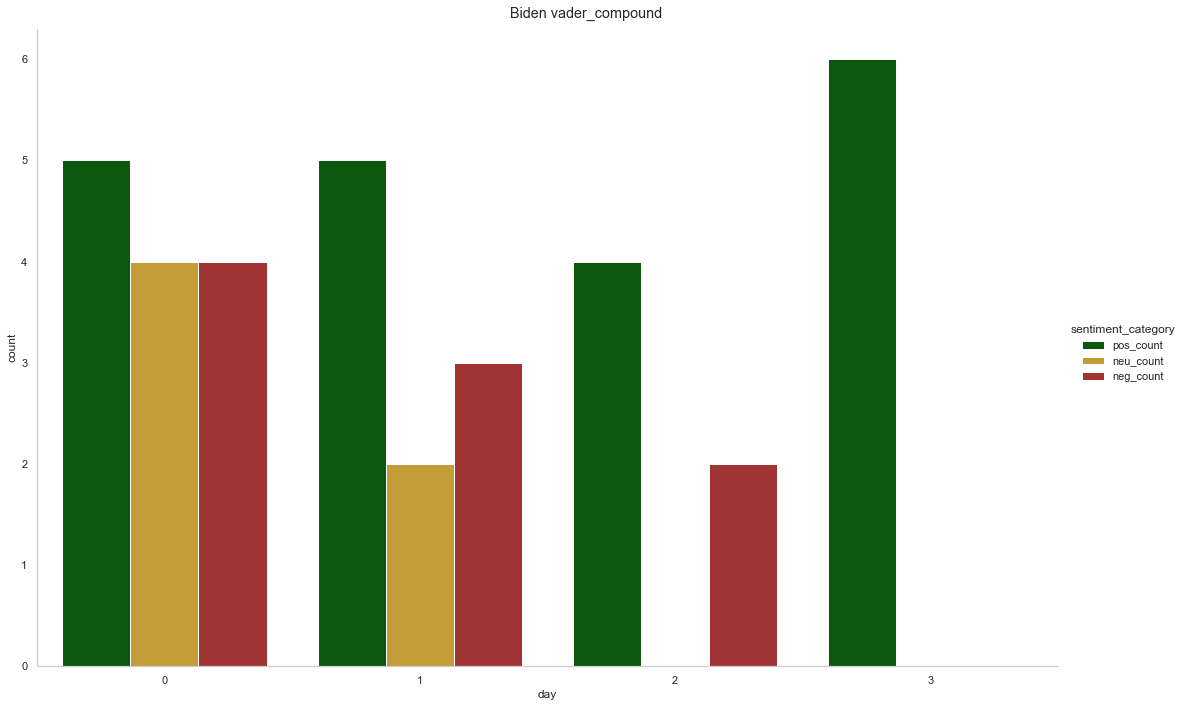

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


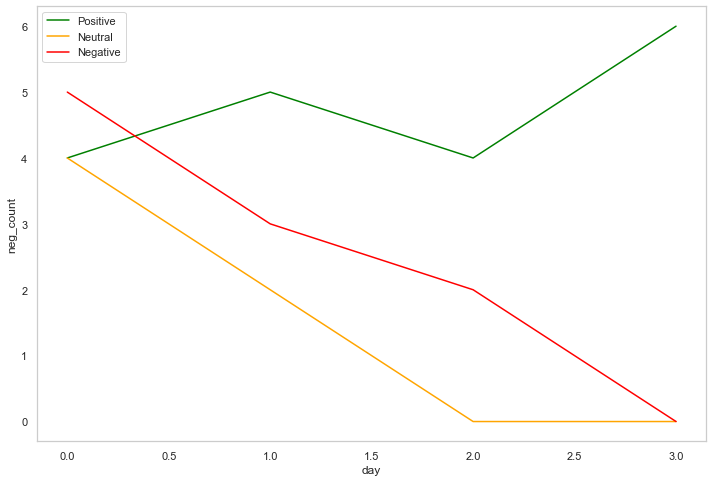

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


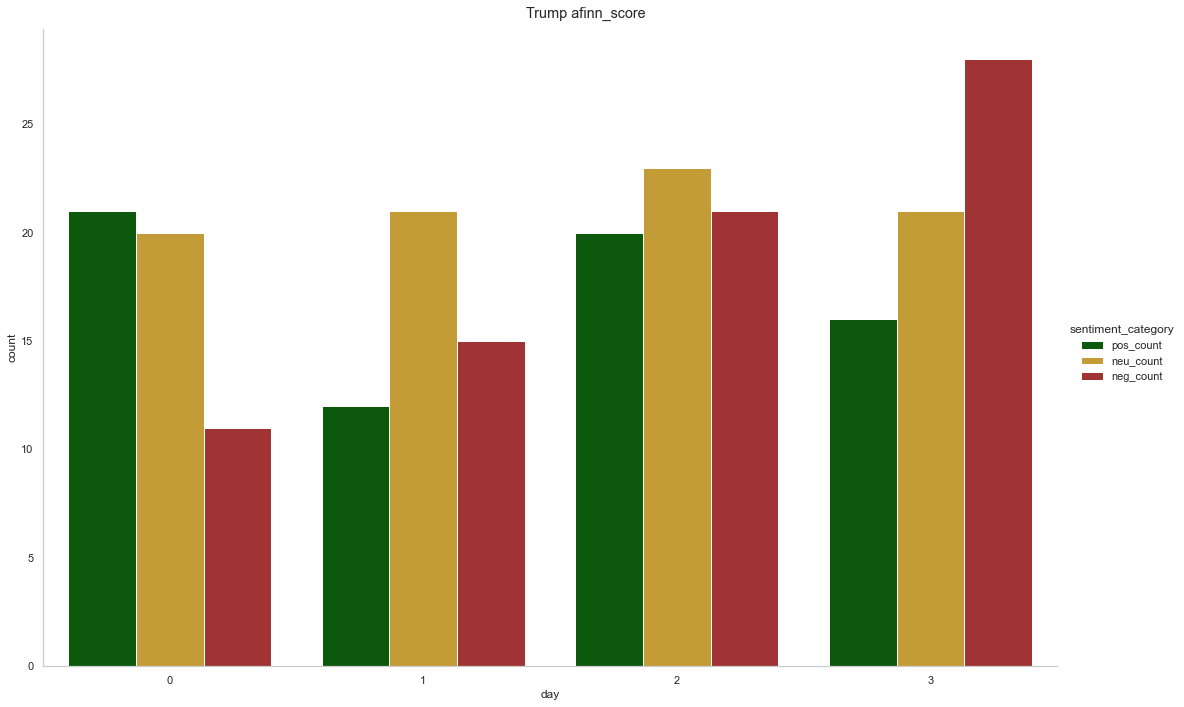

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


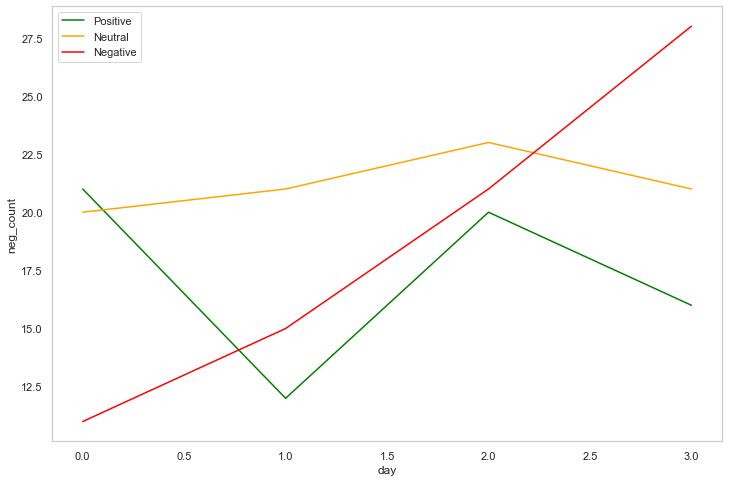

/Users/sarah/miniconda3/envs/91rEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


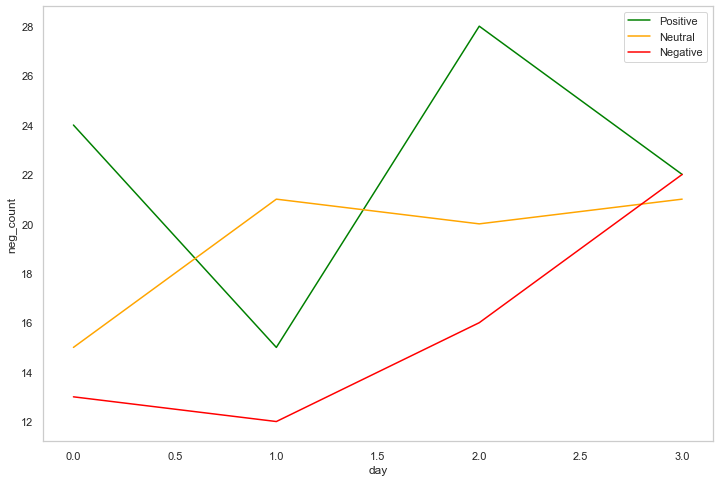

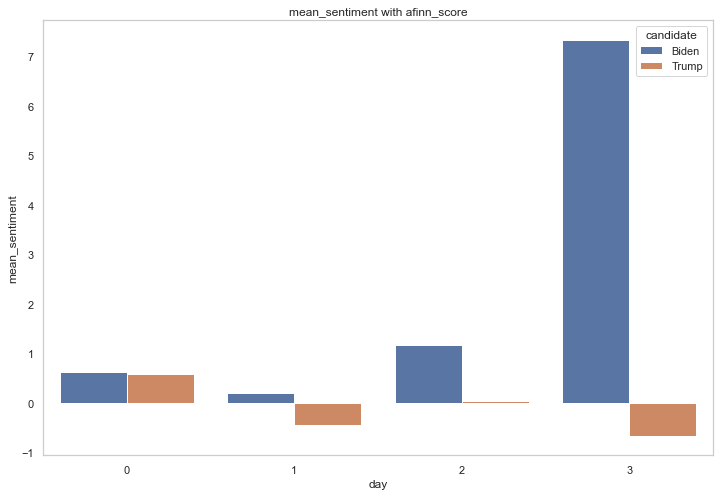

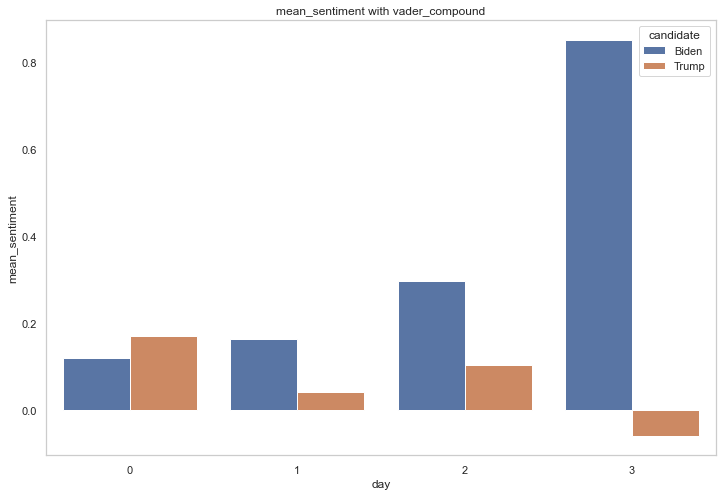

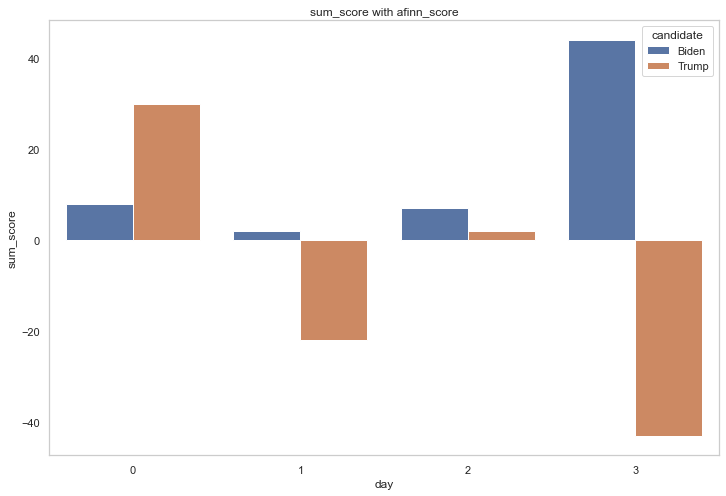

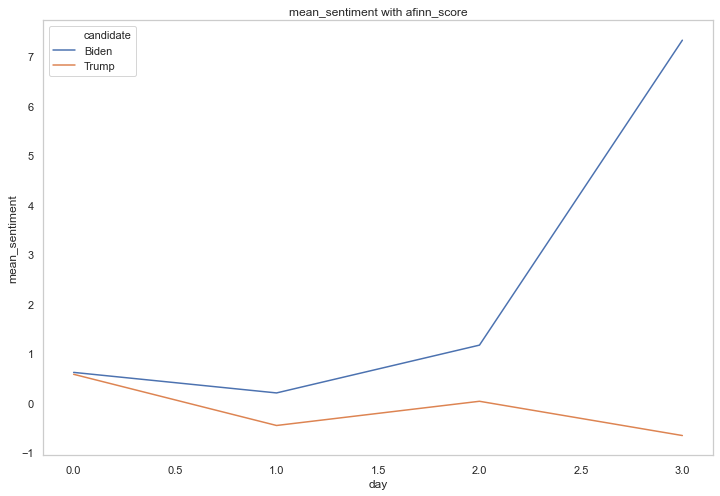

In [384]:
tbdf_plots(tbdf_1112_1115, mentions_1112_1115)

In [396]:
# Edit the day number
tbdf_1112_1115.day = tbdf_1112_1115.day + 42
tbdf_1112_1115

candidate  favorite_count  reply_count  retweet_count  \
0       Trump               0          237              0   
1       Trump          324754           77            101   
2       Trump               0            1              0   
3       Biden          194140           26             23   
4       Trump               0            3              0   
5       Trump          222650          118            119   
6       Trump          164909           72            678   
7       Trump               0           55              0   
8       Trump               0            0              0   
9       Trump               0            0              0   
10      Trump               0            0              0   
11      Trump               0            0              0   
12      Trump               0            0              0   
13      Trump          558995         3487           2541   
14      Trump               0           32              0   
15      Trump               0           45              0   
16      Trump          316652          561            235   
17      Trump               0           18              0   
18      Trump          103564          178             52   
19      Trump           39607           67            172   
20      Trump               0           40              0   
21      Trump          341331            0              4   
22      Trump               0            1              0   
23      Trump               0           88              0   
24      Trump               0           57              0   
25      Trump               0            0              0   
26      Trump               0            0              0   
27      Trump               0            0              0   
28      Trump               0           80              0   
29      Trump          298669          828           2466   
..        ...             ...          ...            ...   
520     Trump               0            1              0   
521     Trump          703730            0              5   
522     Trump               0            1              0   
523     Trump               0            2              0   
524     Trump          164647            0              1   
525     Trump               0            1              0   
526     Trump               0            2              0   
527     Trump          147864            1             10   
528     Trump               0            1              0   
529     Trump               0            2              0   
530     Biden               0            1              0   
531     Trump               0            2              0   
532     Trump          368212            0              1   
533     Biden               0            1              0   
534     Trump               0            1              0   
535     Trump          688280            0              1   
536     Trump            1687            0              1   
537     Trump               0            1              0   
538     Trump          153294            0              1   
539     Biden          163253            0              1   
540     Trump               0            1              0   
541     Trump               0            1              0   
542     Trump               0            1              0   
543     Trump          279280            0              1   
544     Trump               0            1              0   
545     Trump               0            1              0   
546     Trump           38313            0              1   
547     Trump          116082            0              1   
548     Trump               0            1              0   
549     Trump          459624            0              1   

                                                                                                                                                                                                                             

In [397]:
# Append the dataframes
tbdf_1001_1115 = tbdf_1001_1111.append(tbdf_1112_1115)
tbdf_1001_1115

candidate  favorite_count  reply_count  retweet_count  \
0       Biden               0            9              0   
1       Biden           85537            7             10   
2       Trump               0           97              0   
3       Trump           67488           46             48   
4       Trump           42912           14            205   
5       Trump           88775           47            250   
6       Trump               0           17              0   
7       Biden               0           33              0   
8       Biden               0            7              0   
9       Trump           60692           27            207   
10      Trump          319725            5             12   
11      Trump           43804            6              2   
12      Biden           37798           48             12   
13      Trump           62489           58             94   
14      Trump               0           11              0   
15      Trump           65627           30            243   
16      Trump               0           25              0   
17      Trump           42804            2              4   
18      Trump               0            4              0   
19      Biden          126747            6             14   
20      Trump          126808            5              7   
21      Trump           32513            1              5   
22      Trump          106074           31              4   
23      Trump           36220            6             30   
24      Biden               0           21              0   
25      Biden           19239            7              6   
26      Trump               0            1              0   
27      Biden               0           55              0   
28      Trump           67390           33            240   
29      Biden          329081           15             11   
..        ...             ...          ...            ...   
520     Trump               0            1              0   
521     Trump          703730            0              5   
522     Trump               0            1              0   
523     Trump               0            2              0   
524     Trump          164647            0              1   
525     Trump               0            1              0   
526     Trump               0            2              0   
527     Trump          147864            1             10   
528     Trump               0            1              0   
529     Trump               0            2              0   
530     Biden               0            1              0   
531     Trump               0            2              0   
532     Trump          368212            0              1   
533     Biden               0            1              0   
534     Trump               0            1              0   
535     Trump          688280            0              1   
536     Trump            1687            0              1   
537     Trump               0            1              0   
538     Trump          153294            0              1   
539     Biden          163253            0              1   
540     Trump               0            1              0   
541     Trump               0            1              0   
542     Trump               0            1              0   
543     Trump          279280            0              1   
544     Trump               0            1              0   
545     Trump               0            1              0   
546     Trump           38313            0              1   
547     Trump          116082            0              1   
548     Trump               0            1              0   
549     Trump          459624            0              1   

                                                                                                                                                                                                                             

In [401]:
tbdf_1001_1115_no_duplicates = tbdf_1001_1115[tbdf_1001_1115.text != ""].drop_duplicates(subset=['tweet_id'])
tbdf_1001_1115_no_duplicates

candidate  favorite_count  reply_count  retweet_count  \
1       Biden           85537            7             10   
3       Trump           67488           46             48   
4       Trump           42912           14            205   
5       Trump           88775           47            250   
9       Trump           60692           27            207   
10      Trump          319725            5             12   
11      Trump           43804            6              2   
12      Biden           37798           48             12   
13      Trump           62489           58             94   
15      Trump           65627           30            243   
17      Trump           42804            2              4   
19      Biden          126747            6             14   
20      Trump          126808            5              7   
21      Trump           32513            1              5   
22      Trump          106074           31              4   
23      Trump           36220            6             30   
25      Biden           19239            7              6   
28      Trump           67390           33            240   
29      Biden          329081           15             11   
30      Trump          146174           42            286   
31      Biden          347956            2              1   
32      Trump          104901           12              9   
33      Trump          145332            2              7   
34      Biden          863514            0              2   
35      Biden           36839            0              3   
36      Trump          179296           56             33   
37      Biden          547755            5             37   
39      Trump           59489            9             47   
40      Trump           25338            0              1   
42      Trump          101413            5             10   
..        ...             ...          ...            ...   
308     Trump          198552           95             86   
319     Biden          433470          120            340   
321     Trump          207284           31             81   
373     Trump          180211            0              1   
381     Trump           65966            7            268   
387     Trump           34940           18             46   
388     Trump           14023           26            281   
390     Trump           83984            0              1   
394     Trump            1914            0              2   
395     Trump              73            0              1   
412     Trump          149839          292            249   
413     Trump          149341          100             30   
414     Trump          127469           94            655   
419     Trump           95802           18            141   
422     Trump          112280           88              6   
428     Trump           54070           14             94   
433     Trump          263391          223            193   
436     Trump          119645           56            492   
442     Trump           93676           29            194   
443     Trump          276999          208            142   
444     Trump           98017          228           1596   
445     Trump           87600          133            332   
459     Trump           50677           19             86   
463     Biden          285524           32             40   
477     Trump               0            0              0   
478     Trump               0            0              0   
536     Trump            1687            0              1   
538     Trump          153294            0              1   
543     Trump          279280            0              1   
546     Trump           38313            0              1   

                                                                                                                                                                                                                             

In [406]:
tbdf_1001_1115_no_duplicates[["candidate", "text", "tweet_id"]].to_csv(r'trump_biden_tweets.csv', index = False)

In [394]:
tbdf_1001_1111[tbdf_1001_1111.text != ""].drop_duplicates(subset=['tweet_id'])

candidate  favorite_count  reply_count  retweet_count  \
1        Biden           85537            7             10   
3        Trump           67488           46             48   
4        Trump           42912           14            205   
5        Trump           88775           47            250   
9        Trump           60692           27            207   
10       Trump          319725            5             12   
11       Trump           43804            6              2   
12       Biden           37798           48             12   
13       Trump           62489           58             94   
15       Trump           65627           30            243   
17       Trump           42804            2              4   
19       Biden          126747            6             14   
20       Trump          126808            5              7   
21       Trump           32513            1              5   
22       Trump          106074           31              4   
23       Trump           36220            6             30   
25       Biden           19239            7              6   
28       Trump           67390           33            240   
29       Biden          329081           15             11   
30       Trump          146174           42            286   
31       Biden          347956            2              1   
32       Trump          104901           12              9   
33       Trump          145332            2              7   
34       Biden          863514            0              2   
35       Biden           36839            0              3   
36       Trump          179296           56             33   
37       Biden          547755            5             37   
39       Trump           59489            9             47   
40       Trump           25338            0              1   
42       Trump          101413            5             10   
...        ...             ...          ...            ...   
7970     Trump           82756           19              5   
7975     Trump            1461            0              1   
7978     Trump           44951            0              1   
7980     Trump          164226            0              2   
7982     Trump           73559            0              1   
7983     Biden           93160            9             21   
7985     Trump           85718           16             56   
7999     Trump              73            0              1   
8011     Trump          418591            0              1   
8013     Trump            1364           38             92   
8018     Trump            3999            0              1   
8034     Trump          319731          221            157   
8037     Trump          290772          207            205   
8040     Trump          120495           66            257   
8041     Trump          278119          151            172   
8042     Biden          214979           25             43   
8046     Trump           21277            0              1   
8048     Trump          182281          167            145   
8056     Trump          186942           83            130   
8061     Biden          121208           22             26   
8068     Trump          251516           82             90   
8073     Trump           50588            0              1   
8096     Trump           66355            0              1   
8097     Trump           57279            0              1   
8098     Trump             595            0              1   
8099     Trump           63637            0              1   
8127     Trump          235276            0              1   
8135     Trump          225759            0              1   
8137     Trump          274664            0              2   
8172     Trump            1095            0              1   

                                                                                                                                                                